# Summary

This notebook provides a comprehensive analysis and modeling of historical order data. The workflow is divided into several sections:

1. [Exploratory Data Analysis (EDA)](#EDA)
2. [Comparison between Datasets](#Comparison-between-the-three-datasets)
3. [Modeling](#Modelling)
4. [Preprocessing](#preprocessing)
5. [Model Training and Evaluation](#Model-Training-and-Evaluation)

## Sections

### EDA
- Initial exploration of historical orders data.
- Analysis of missing values and distribution of orders per account.
- Visualization of seasonal patterns and trends.

### Comparison between the three datasets
- Comparison of historical orders, total sales, and missing orders datasets.
- Analysis of missing data and distribution of orders across datasets.

### Modelling
- Preprocessing steps for modeling.
- Feature engineering and creation of training datasets.
- Handling of outliers and filtering records.

### Model Training and Evaluation
- Training and evaluation of various models including Linear Regression, Random Forest, KNN, Naive Bayes, and SVM.
- Metrics and visualizations for model performance.

[Link to EDA](#EDA)

[Link to Comparison between the three datasets](#Comparison-between-the-three-datasets)

[Link to Modelling](#Modelling)

[Link to preprocessing](#preprocessing)

[Link to Model Training and Evaluation](#Model-Training-and-Evaluation)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL,seasonal_decompose

from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR 
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression


## EDA

Historical Orders

In [2]:
path_historical_orders='data_files_challenge/historical_orders.parquet'
df_raw_historical_orders=pd.read_parquet(path_historical_orders)
df_raw_historical_orders.head()

,account_id,order_date,transaction_amount
0,BR_09607801000194,2021-08-28,11011.2
1,BR_09607801000194,2021-08-28,13764.0
2,BR_09607801000194,2021-08-28,11011.2
3,BR_09607801000194,2021-08-28,11011.2
4,BR_09607801000194,2021-08-28,13764.0


In [3]:
pd.concat([df_raw_historical_orders.isna().sum(),
           df_raw_historical_orders.isna().sum()/len(df_raw_historical_orders)*100],axis=1)\
    .rename(columns={0:'missing_values',1:'missing_values_%'})
           

,missing_values,missing_values_%
account_id,0,0.0
order_date,0,0.0
transaction_amount,0,0.0


In [4]:
df_raw_historical_orders['account_id'].value_counts().describe()

count    47899.000000
mean       179.479258
std        297.862192
min          1.000000
25%         25.000000
50%         81.000000
75%        210.000000
max       6710.000000
Name: account_id, dtype: float64

given the deviation between the mean and the meadian the boxplot chart will be inspected

Text(0.5, 1.0, 'Number of orders per account')

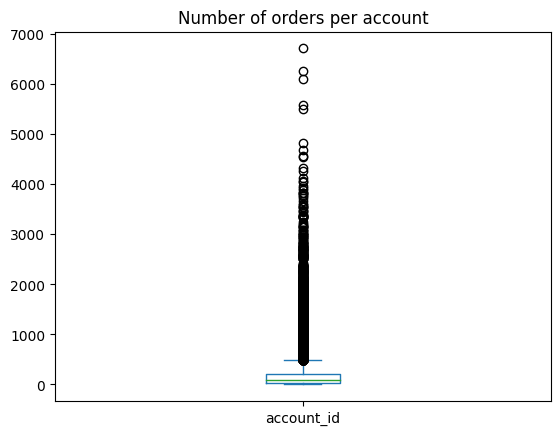

In [5]:
df_raw_historical_orders['account_id'].value_counts().plot(kind='box')
plt.title('Number of orders per account')

In [6]:
df_raw_historical_orders[['account_id','transaction_amount']].groupby('account_id').sum()\
    .sort_values('transaction_amount',ascending=False).describe()

,transaction_amount
count,4.789900e+04
mean,4.944942e+04
std,4.359496e+05
min,-1.455300e+04
25%,1.927555e+03
50%,7.952770e+03
75%,2.879231e+04
max,4.268275e+07


In [7]:
filter_out_negative_values=df_raw_historical_orders['transaction_amount']>=0

Text(0.5, 1.0, 'Log of total transaction amount per account')

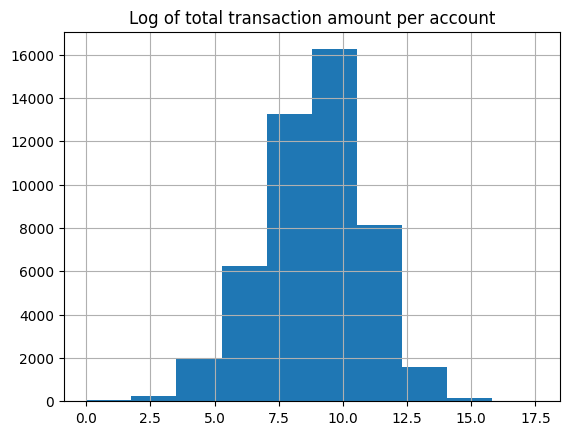

In [8]:
df_raw_historical_orders[filter_out_negative_values][['account_id','transaction_amount']].groupby('account_id').sum()\
    .sort_values('transaction_amount',ascending=False)\
    ['transaction_amount']\
    .apply(lambda x: np.log(x+1))\
    .hist(density=False)
plt.title('Log of total transaction amount per account')

In [9]:
df_raw_historical_orders[(~filter_out_negative_values)&(df_raw_historical_orders['transaction_amount'].notna())].describe()

,transaction_amount
count,95131.000000
mean,-98.949856
std,2.853571
min,-607.500000
25%,-99.000000
50%,-99.000000
75%,-99.000000
max,-0.010000


it is problably a typo, where the negative signal was misplaced. Even if it was sourced by a discount, it was an order, then it should be accounted as regular order. 

In [10]:
df_raw_historical_orders.groupby('order_date').agg({'transaction_amount':['sum','count']}).droplevel(0,axis=1)\
    .corr()

,sum,count
sum,1.000000,0.935096
count,0.935096,1.000000


High correlation between the number of orders and the total transaction amount

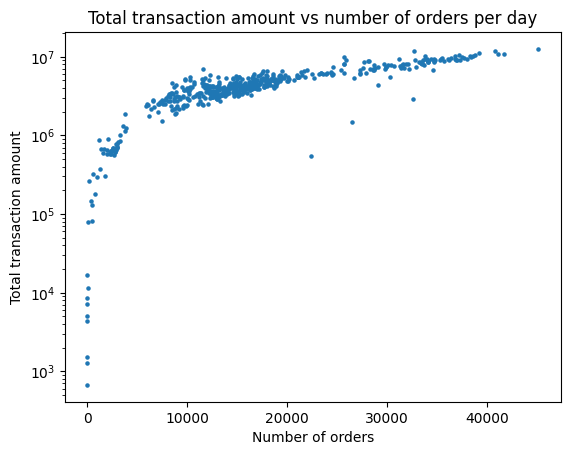

In [11]:
df_raw_historical_orders.groupby('order_date').agg({'transaction_amount':['sum','count']}).droplevel(0,axis=1)\
    .plot.scatter(x='count',y='sum',s=5)
plt.title('Total transaction amount vs number of orders per day')
plt.xlabel('Number of orders')
plt.ylabel('Total transaction amount')
plt.yscale('log')


In [12]:
df_raw_historical_orders['order_date']=pd.to_datetime(df_raw_historical_orders['order_date'])

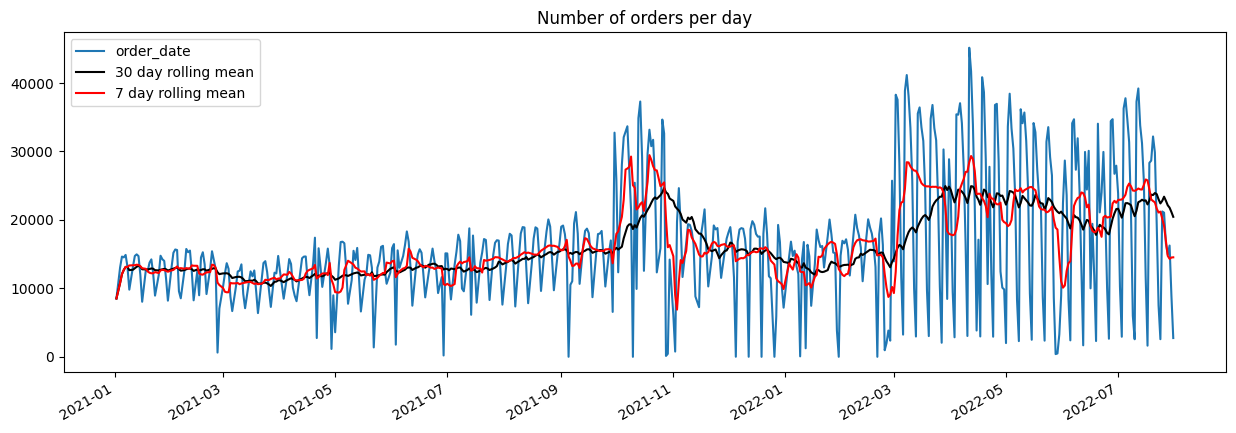

In [13]:
df_raw_historical_orders['order_date'].value_counts().plot(figsize=(15,5))
plt.xticks(rotation=45)
df_raw_historical_orders['order_date'].value_counts().sort_index().rolling('30D').mean()\
    .plot(figsize=(15,5),label='30 day rolling mean',color='black')
plt.title('Number of orders per day')
df_raw_historical_orders['order_date'].value_counts().sort_index().rolling('7D').mean()\
    .plot(figsize=(15,5),label='7 day rolling mean',color='red')
plt.title('Number of orders per day')
plt.legend()

<Axes: >

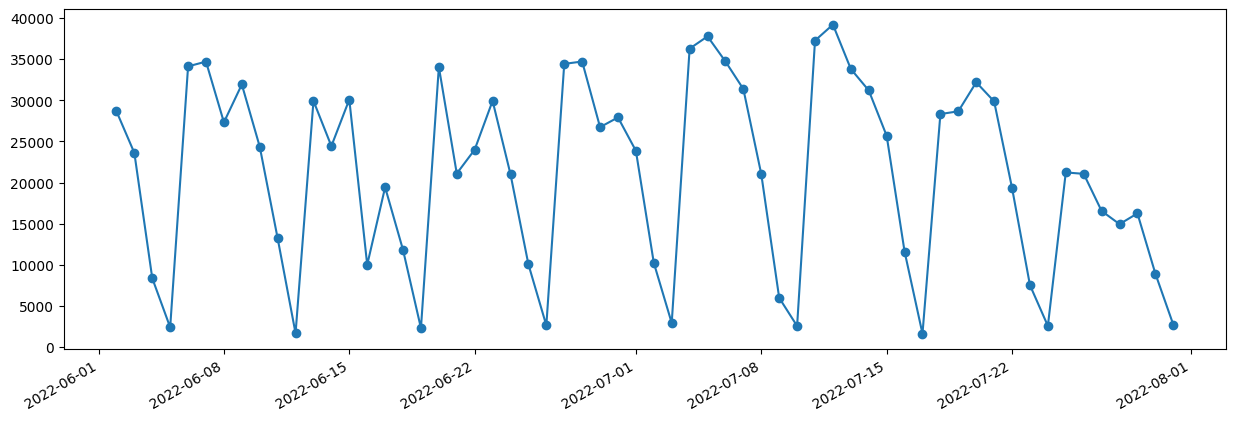

In [14]:
filter_last_60_days=df_raw_historical_orders['order_date']>df_raw_historical_orders['order_date'].max()-pd.Timedelta(days=60)
df_raw_historical_orders[filter_last_60_days]['order_date'].value_counts()\
    .plot(figsize=(15,5),marker='o')


There is a clear seasonal behavior around the weeks.

In [15]:
df_raw_historical_orders['order_date_weekday']=df_raw_historical_orders['order_date'].dt.weekday
df_raw_historical_orders['order_date_weekend']=df_raw_historical_orders['order_date'].dt.weekday.isin([5,6])


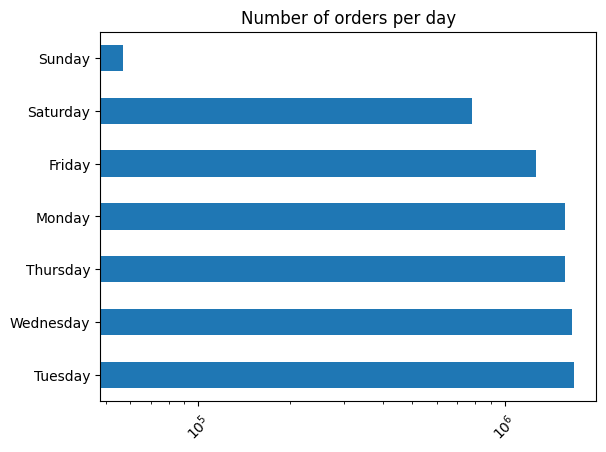

In [16]:
df_raw_historical_orders['order_date_weekday'].value_counts()\
    .rename({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})\
    .plot(kind='barh')

plt.xticks(rotation=45)
plt.title('Number of orders per day')
plt.xscale('log')

since there is a high correlation between the number of orders and the total transaction amount, 
it is not required to inspect the transaction amount, the number of order works as a proxy for the total transaction amount

Text(0.5, 1.0, 'Number of orders by weekday/weekend')

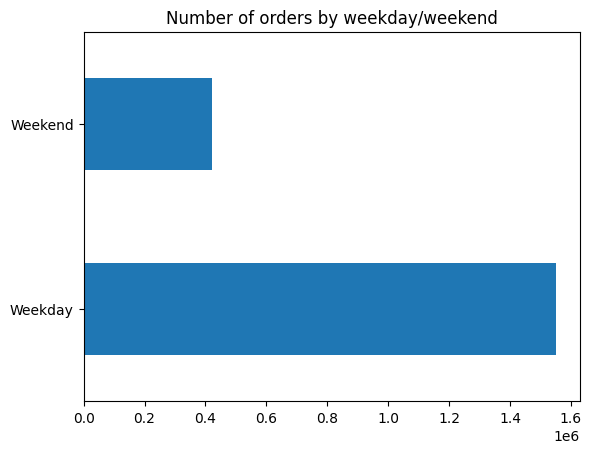

In [17]:
(df_raw_historical_orders['order_date_weekend'].value_counts()/pd.Series([5,2],index=[False,True]))\
    .rename({False:'Weekday',True:'Weekend'})\
    .plot(kind='barh')
#normalized by number of days in the week
plt.title('Number of orders by weekday/weekend')


### Comparison between the three datasets

august_total_sales


In [18]:
path_total_sales='data_files_challenge/august_total_sales.parquet'
df_raw_total_sales=pd.read_parquet(path_total_sales)
df_raw_total_sales.head()

,account_id,total_transaction_amount_august
0,BR_00000343803,309.99
1,BR_00001415930,874.98
2,BR_00001760106,11976.70
3,BR_00002485176,511.48
4,BR_00002536340,7081.14


august_missing_orders

In [19]:
path_august_missing_orders='data_files_challenge/august_with_missing_order_days.parquet'
df_raw_august_missing_orders=pd.read_parquet(path_august_missing_orders)
df_raw_august_missing_orders.head()

,account_id,order_date,transaction_amount
0,BR_09532176632,2022-08-03,11.16
1,BR_09532176632,2022-08-03,32.52
2,BR_09532176632,2022-08-03,24.90
3,BR_09532176632,2022-08-03,28.50
4,BR_09532176632,2022-08-03,11.16


Amount of missing data

In [20]:
def missing_values(df,id=None):
    df=pd.concat([df.isna().sum(),
           df.isna().sum()/len(df)*100],axis=1)\
    .rename(columns={0:'missing_values',1:'missing_values_%'})
    if id is not None:
        df['id']=id
    return df

In [21]:
pd.concat([missing_values(df_raw_total_sales,id='total_sales'),\
           missing_values(df_raw_august_missing_orders,'august_missing_orders'),
           missing_values(df_raw_historical_orders,'historical_orders')])\
            .pivot(columns='id')

missing_values                    \
id                              august_missing_orders historical_orders   
account_id                                        0.0               0.0   
order_date                                    13438.0               0.0   
order_date_weekday                                NaN               0.0   
order_date_weekend                                NaN               0.0   
total_transaction_amount_august                   NaN               NaN   
transaction_amount                            13438.0               0.0   

                                                 missing_values_%  \
id                              total_sales august_missing_orders   
account_id                              0.0              0.000000   
order_date                              NaN              4.229311   
order_date_weekday                      NaN                   NaN   
order_date_weekend                      NaN                   NaN   
total_transaction_amount_august         0.0                   NaN   
transaction_amount                      NaN              4.229311   

                                                               
id                              historical_orders total_sales  
account_id                                    0.0         0.0  
order_date                                    0.0         NaN  
order_date_weekday                            0.0         NaN  
order_date_weekend                            0.0         NaN  
total_transaction_amount_august               NaN         0.0  
transaction_amount                            0.0         NaN

Text(0.5, 0.98, 'Number of orders per account')

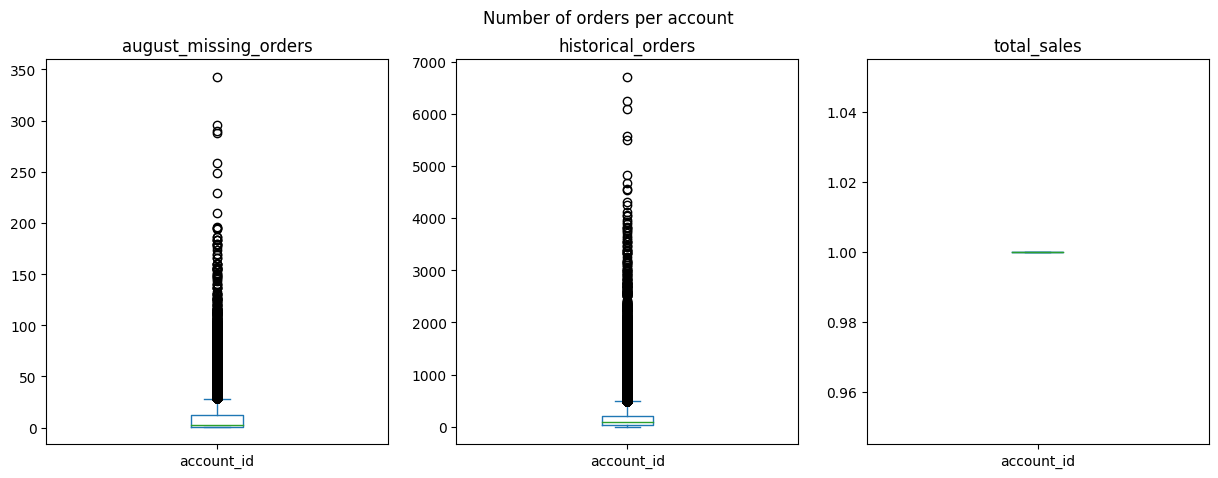

In [22]:
fig,axs=plt.subplots(1,3,figsize=(15,5))

df_raw_august_missing_orders['account_id'].value_counts().plot(kind='box',ax=axs[0])
axs[0].set_title('august_missing_orders')

df_raw_historical_orders['account_id'].value_counts().plot(kind='box',ax=axs[1])
axs[1].set_title('historical_orders')

df_raw_total_sales['account_id'].value_counts().plot(kind='box',ax=axs[2])
axs[2].set_title('total_sales')

plt.suptitle('Number of orders per account')


In [23]:
df_raw_total_sales
 

,account_id,total_transaction_amount_august
0,BR_00000343803,309.99
1,BR_00001415930,874.98
2,BR_00001760106,11976.70
3,BR_00002485176,511.48
4,BR_00002536340,7081.14
...,...,...
32939,BR_99904403791,2996.69
32940,BR_99910241587,4225.98
32941,BR_99936259300,646.44
32942,BR_99946866587,494.36


Text(0.5, 0.98, 'Log of total transaction amount per account')

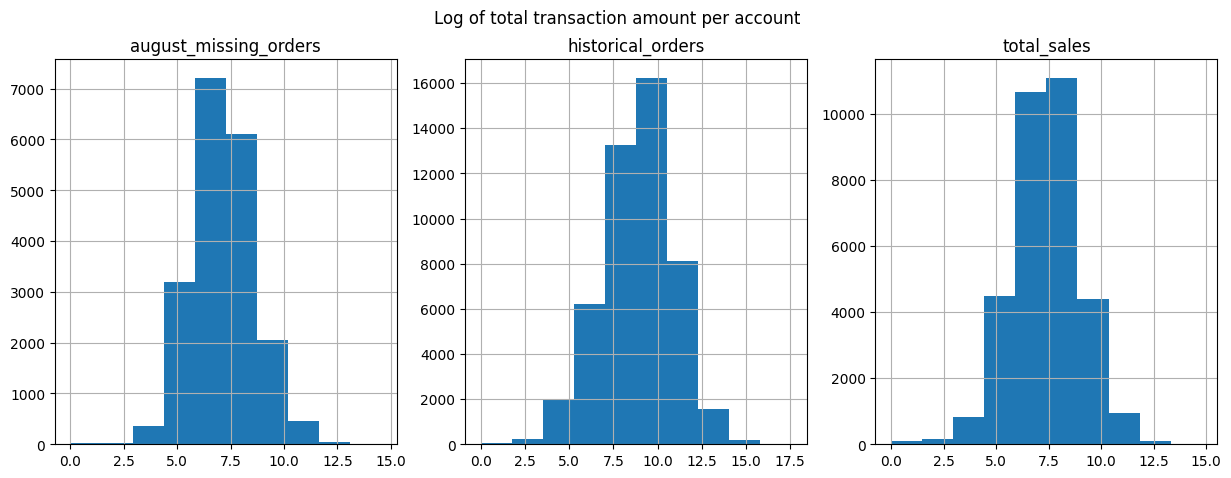

In [24]:

def histogram_log_total_transaction(df,ax,account_column='account_id',transaction_column='transaction_amount'):
    filter_out_negative_values=df[transaction_column]>=0
    df[filter_out_negative_values][[account_column,transaction_column]].groupby(account_column).sum()\
        .sort_values(transaction_column,ascending=False)\
        [transaction_column]\
        .apply(lambda x: np.log(x+1))\
        .hist(density=False,ax=ax)


fig,axs=plt.subplots(1,3,figsize=(15,5))
histogram_log_total_transaction(df_raw_august_missing_orders,ax=axs[0])
axs[0].set_title('august_missing_orders')
histogram_log_total_transaction(df_raw_historical_orders,ax=axs[1])
axs[1].set_title('historical_orders')
histogram_log_total_transaction(df_raw_total_sales,ax=axs[2],transaction_column='total_transaction_amount_august')
axs[2].set_title('total_sales')
plt.suptitle('Log of total transaction amount per account')

Text(0.5, 1.0, 'historical_orders')

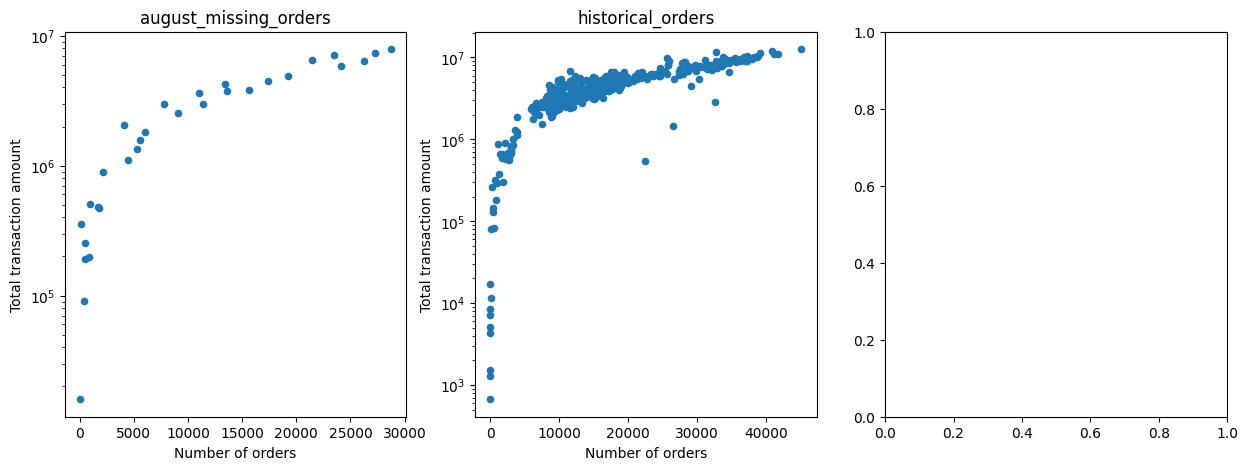

In [25]:
def plot_scatter(df,x,y,ax):
    df.groupby(x).agg({y:['sum','count']}).droplevel(0,axis=1)\
        .plot.scatter(x='count',y='sum',ax=ax)
    ax.set_xlabel('Number of orders')
    ax.set_ylabel('Total transaction amount')
    ax.set_yscale('log')

fig,axs=plt.subplots(1,3,figsize=(15,5))
plot_scatter(df_raw_august_missing_orders,'order_date','transaction_amount',axs[0])
axs[0].set_title('august_missing_orders')
plot_scatter(df_raw_historical_orders,'order_date','transaction_amount',axs[1])
axs[1].set_title('historical_orders')


In [26]:
df_raw_august_missing_orders['order_date']=pd.to_datetime(df_raw_august_missing_orders['order_date'])


Text(0.5, 0.98, 'Number of orders per day')

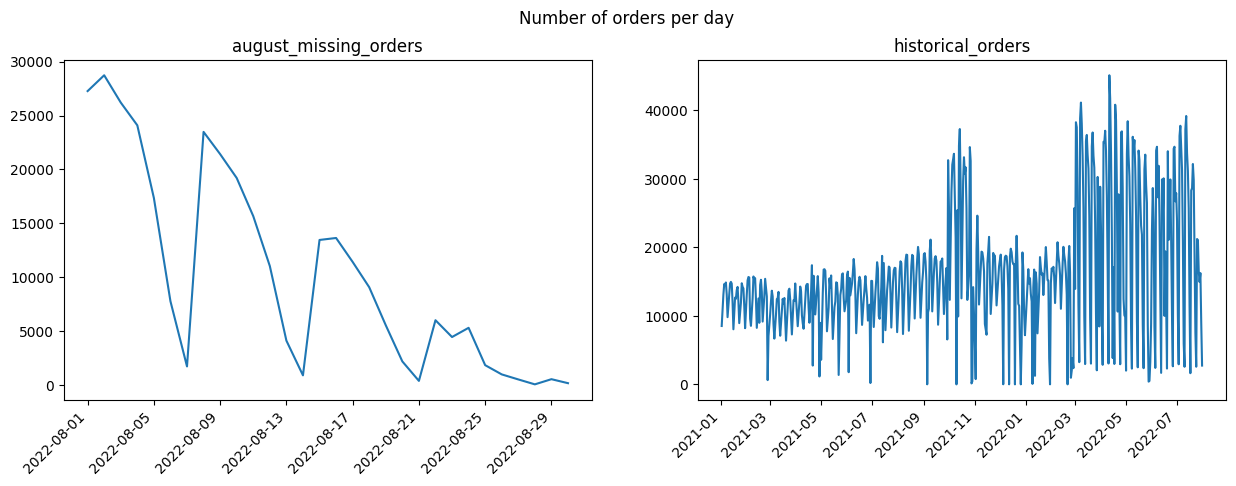

In [27]:
fig,axs=plt.subplots(1,2,figsize=(15,5))

df_raw_august_missing_orders['order_date'].value_counts().plot(ax=axs[0])
axs[0].tick_params(axis='x', rotation=45)
axs[0].set_title('august_missing_orders')

df_raw_historical_orders['order_date'].value_counts().plot(ax=axs[1])
axs[1].tick_params(axis='x', rotation=45)
axs[1].set_title('historical_orders')

plt.suptitle('Number of orders per day')



there is a clear seasonality in the number of orders per day in august, with a peak every 7 days which is probably monday given the chart bellow. Also there is a descending trend. 

In [28]:
df_raw_august_missing_orders['order_date_weekday']=df_raw_august_missing_orders['order_date'].dt.weekday
df_raw_august_missing_orders['order_date_weekend']=df_raw_august_missing_orders['order_date'].dt.weekday.isin([5,6])


Text(0.5, 0.98, 'Number of orders by weekday/weekend')

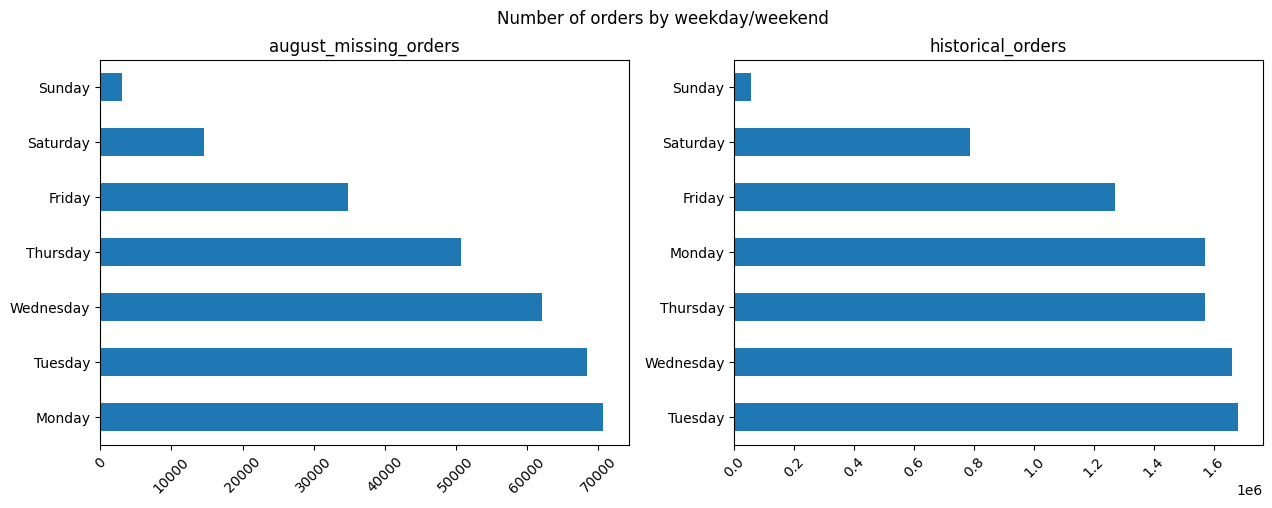

In [29]:


fig,axs=plt.subplots(1,2,figsize=(15,5))

df_raw_august_missing_orders['order_date_weekday'].value_counts()\
    .rename({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})\
    .plot(kind='barh',ax=axs[0])
axs[0].tick_params(axis='x', rotation=45)
axs[0].set_title('august_missing_orders')

df_raw_historical_orders['order_date_weekday'].value_counts()\
    .rename({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})\
    .plot(kind='barh',ax=axs[1])
axs[1].tick_params(axis='x', rotation=45)
axs[1].set_title('historical_orders')

plt.suptitle('Number of orders by weekday/weekend')

Text(0.5, 0.98, 'Number of orders by weekday/weekend')

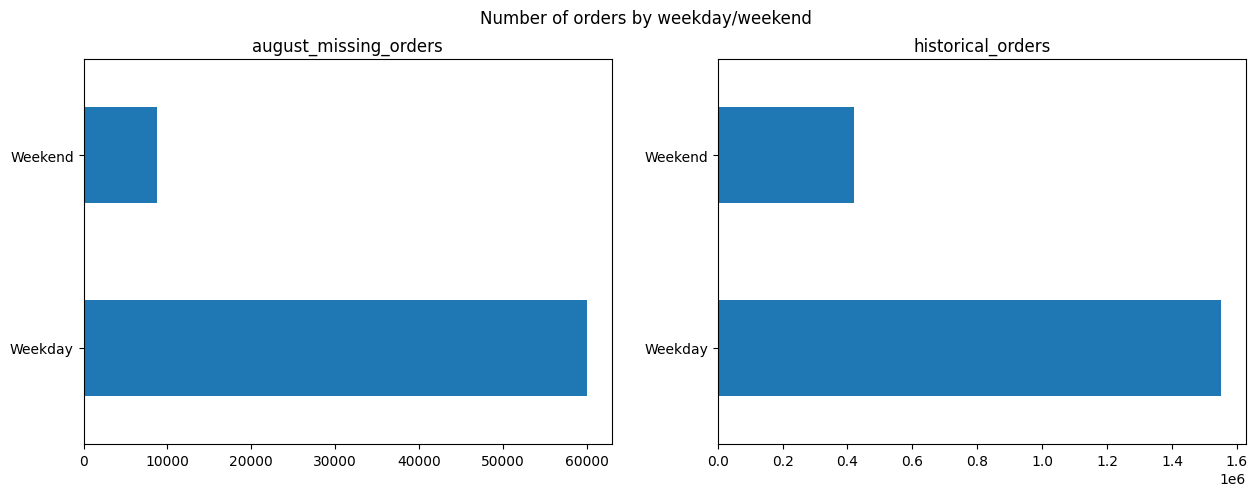

In [30]:
fig,axs=plt.subplots(1,2,figsize=(15,5))

(df_raw_august_missing_orders['order_date_weekend'].value_counts()/pd.Series([5,2],index=[False,True]))\
    .rename({False:'Weekday',True:'Weekend'})\
    .plot(kind='barh',ax=axs[0])
#normalized by number of days in the week
axs[0].set_title('august_missing_orders')

(df_raw_historical_orders['order_date_weekend'].value_counts()/pd.Series([5,2],index=[False,True]))\
    .rename({False:'Weekday',True:'Weekend'})\
    .plot(kind='barh',ax=axs[1])
#normalized by number of days in the week
axs[1].set_title('historical_orders')

plt.suptitle('Number of orders by weekday/weekend')

# Modelling

### preprocessing

In [31]:
path_historical_orders='data_files_challenge/historical_orders.parquet'
df_raw_historical_orders=pd.read_parquet(path_historical_orders)
df_raw_historical_orders.head()

,account_id,order_date,transaction_amount
0,BR_09607801000194,2021-08-28,11011.2
1,BR_09607801000194,2021-08-28,13764.0
2,BR_09607801000194,2021-08-28,11011.2
3,BR_09607801000194,2021-08-28,11011.2
4,BR_09607801000194,2021-08-28,13764.0


In [32]:
df_historical_orders=df_raw_historical_orders.copy()
df_historical_orders['order_date']=pd.to_datetime(df_historical_orders['order_date'])
df_historical_orders['transaction_amount']=df_historical_orders['transaction_amount'].astype(float)
df_historical_orders['account_id']=df_historical_orders['account_id'].astype('category')

filter_negative_values=df_historical_orders['transaction_amount']<0
df_historical_orders.loc[filter_negative_values,'transaction_amount']=df_historical_orders['transaction_amount']*-1.
df_historical_orders['month']=df_historical_orders['order_date']-pd.offsets.MonthBegin(1)

In [33]:
df_historical_orders.sort_values('month',ascending=False).head()

,account_id,order_date,transaction_amount,month
6301598,BR_94596832072,2022-07-18,66.11,2022-07-01
8648686,BR_01817563000130,2022-07-11,213.39,2022-07-01
8648698,BR_22697600000193,2022-07-11,182.00,2022-07-01
8648697,BR_08385302000137,2022-07-11,170.00,2022-07-01
8648696,BR_21243881000141,2022-07-11,88.56,2022-07-01


In [34]:
df_trainning=df_historical_orders[['account_id','month','transaction_amount']].groupby(['account_id','month'])\
    .agg(transaction_sum=('transaction_amount', 'sum'), 
        transaction_count=('transaction_amount', 'count')).reset_index()

In [35]:
df_trainning

,account_id,month,transaction_sum,transaction_count
0,BR_00000343803,2021-01-01,814.92,7
1,BR_00000343803,2021-02-01,484.76,4
2,BR_00000343803,2021-03-01,661.68,6
3,BR_00000343803,2021-04-01,575.08,4
4,BR_00000343803,2021-05-01,859.12,8
...,...,...,...,...
910076,BR_99980878134,2022-03-01,0.00,0
910077,BR_99980878134,2022-04-01,0.00,0
910078,BR_99980878134,2022-05-01,0.00,0
910079,BR_99980878134,2022-06-01,0.00,0


In [36]:
df_trainning[df_trainning.account_id=='BR_22697600000193']

,account_id,month,transaction_sum,transaction_count
399152,BR_22697600000193,2021-01-01,0.00,0
399153,BR_22697600000193,2021-02-01,0.00,0
399154,BR_22697600000193,2021-03-01,0.00,0
399155,BR_22697600000193,2021-04-01,0.00,0
399156,BR_22697600000193,2021-05-01,0.00,0
399157,BR_22697600000193,2021-06-01,0.00,0
399158,BR_22697600000193,2021-07-01,0.00,0
399159,BR_22697600000193,2021-08-01,0.00,0
399160,BR_22697600000193,2021-09-01,6245.00,1
399161,BR_22697600000193,2021-10-01,33526.82,57


In [37]:
for offset in range(1,13):
    df_trainning[f'previus_{offset}_month'] = df_trainning['month'] - pd.DateOffset(months=offset)
    df_trainning=df_trainning\
                    .merge(df_trainning[['account_id','month','transaction_sum','transaction_count']],
                   left_on=['account_id',f'previus_{offset}_month'],how='left',
                   right_on=['account_id','month'],suffixes=('',f'_previus_{offset}_month')) 
    df_trainning=df_trainning.drop(columns=[f'month_previus_{offset}_month'])


In [38]:
df_trainning[df_trainning.account_id=='BR_22697600000193'].iloc[:, :20].head()

,account_id,month,transaction_sum,transaction_count,previus_1_month,transaction_sum_previus_1_month,transaction_count_previus_1_month,previus_2_month,transaction_sum_previus_2_month,transaction_count_previus_2_month,previus_3_month,transaction_sum_previus_3_month,transaction_count_previus_3_month,previus_4_month,transaction_sum_previus_4_month,transaction_count_previus_4_month,previus_5_month,transaction_sum_previus_5_month,transaction_count_previus_5_month,previus_6_month
399152,BR_22697600000193,2021-01-01,0.0,0,2020-12-01,NaN,NaN,2020-11-01,NaN,NaN,2020-10-01,NaN,NaN,2020-09-01,NaN,NaN,2020-08-01,NaN,NaN,2020-07-01
399153,BR_22697600000193,2021-02-01,0.0,0,2021-01-01,0.0,0.0,2020-12-01,NaN,NaN,2020-11-01,NaN,NaN,2020-10-01,NaN,NaN,2020-09-01,NaN,NaN,2020-08-01
399154,BR_22697600000193,2021-03-01,0.0,0,2021-02-01,0.0,0.0,2021-01-01,0.0,0.0,2020-12-01,NaN,NaN,2020-11-01,NaN,NaN,2020-10-01,NaN,NaN,2020-09-01
399155,BR_22697600000193,2021-04-01,0.0,0,2021-03-01,0.0,0.0,2021-02-01,0.0,0.0,2021-01-01,0.0,0.0,2020-12-01,NaN,NaN,2020-11-01,NaN,NaN,2020-10-01
399156,BR_22697600000193,2021-05-01,0.0,0,2021-04-01,0.0,0.0,2021-03-01,0.0,0.0,2021-02-01,0.0,0.0,2021-01-01,0.0,0.0,2020-12-01,NaN,NaN,2020-11-01


In [39]:
count_columns=df_trainning.columns[df_trainning.columns.str.contains('count')]
df_trainning[count_columns].isna().sum()

account_id                                 0
transaction_count                          0
transaction_count_previus_1_month      47899
transaction_count_previus_2_month      95798
transaction_count_previus_3_month     143697
transaction_count_previus_4_month     191596
transaction_count_previus_5_month     239495
transaction_count_previus_6_month     287394
transaction_count_previus_7_month     335293
transaction_count_previus_8_month     383192
transaction_count_previus_9_month     431091
transaction_count_previus_10_month    478990
transaction_count_previus_11_month    526889
transaction_count_previus_12_month    574788
dtype: int64

In [40]:
df_trainning=df_trainning.fillna(0)

In [41]:
df_trainning[df_trainning.account_id=='BR_22697600000193'].tail()

,account_id,month,transaction_sum,transaction_count,previus_1_month,transaction_sum_previus_1_month,transaction_count_previus_1_month,previus_2_month,transaction_sum_previus_2_month,transaction_count_previus_2_month,...,transaction_count_previus_9_month,previus_10_month,transaction_sum_previus_10_month,transaction_count_previus_10_month,previus_11_month,transaction_sum_previus_11_month,transaction_count_previus_11_month,previus_12_month,transaction_sum_previus_12_month,transaction_count_previus_12_month
399166,BR_22697600000193,2022-03-01,52446.92,75,2022-02-01,5312.12,7.0,2022-01-01,0.00,0.0,...,0.0,2021-05-01,0.0,0.0,2021-04-01,0.0,0.0,2021-03-01,0.0,0.0
399167,BR_22697600000193,2022-04-01,40411.16,54,2022-03-01,52446.92,75.0,2022-02-01,5312.12,7.0,...,0.0,2021-06-01,0.0,0.0,2021-05-01,0.0,0.0,2021-04-01,0.0,0.0
399168,BR_22697600000193,2022-05-01,18126.44,24,2022-04-01,40411.16,54.0,2022-03-01,52446.92,75.0,...,0.0,2021-07-01,0.0,0.0,2021-06-01,0.0,0.0,2021-05-01,0.0,0.0
399169,BR_22697600000193,2022-06-01,4586.00,4,2022-05-01,18126.44,24.0,2022-04-01,40411.16,54.0,...,1.0,2021-08-01,0.0,0.0,2021-07-01,0.0,0.0,2021-06-01,0.0,0.0
399170,BR_22697600000193,2022-07-01,21338.54,38,2022-06-01,4586.00,4.0,2022-05-01,18126.44,24.0,...,57.0,2021-09-01,6245.0,1.0,2021-08-01,0.0,0.0,2021-07-01,0.0,0.0


In [42]:
df_trainning=df_trainning.fillna(0)

In [43]:
df_trainning['transaction_sum_max_last_12_months']=df_trainning[[f'transaction_sum_previus_{offset}_month' for offset in range(1,13)]].fillna(0).max(axis=1)
df_trainning['transaction_sum_min_last_12_months']=df_trainning[[f'transaction_sum_previus_{offset}_month' for offset in range(1,13)]].fillna(0).min(axis=1)
df_trainning['transaction_sum_median_last_12_months']=df_trainning[[f'transaction_sum_previus_{offset}_month' for offset in range(1,13)]].fillna(0).median(axis=1)

df_trainning['transaction_count_max_last_12_months']=df_trainning[[f'transaction_count_previus_{offset}_month' for offset in range(1,13)]].fillna(0).max(axis=1)
df_trainning['transaction_count_min_last_12_months']=df_trainning[[f'transaction_count_previus_{offset}_month' for offset in range(1,13)]].fillna(0).min(axis=1)
df_trainning['transaction_count_median_last_12_months']=df_trainning[[f'transaction_count_previus_{offset}_month' for offset in range(1,13)]].fillna(0).median(axis=1)

In [44]:
df_trainning[df_trainning.account_id=='BR_22697600000193'].tail()

,account_id,month,transaction_sum,transaction_count,previus_1_month,transaction_sum_previus_1_month,transaction_count_previus_1_month,previus_2_month,transaction_sum_previus_2_month,transaction_count_previus_2_month,...,transaction_count_previus_11_month,previus_12_month,transaction_sum_previus_12_month,transaction_count_previus_12_month,transaction_sum_max_last_12_months,transaction_sum_min_last_12_months,transaction_sum_median_last_12_months,transaction_count_max_last_12_months,transaction_count_min_last_12_months,transaction_count_median_last_12_months
399166,BR_22697600000193,2022-03-01,52446.92,75,2022-02-01,5312.12,7.0,2022-01-01,0.00,0.0,...,0.0,2021-03-01,0.0,0.0,33526.82,0.0,0.00,57.0,0.0,0.0
399167,BR_22697600000193,2022-04-01,40411.16,54,2022-03-01,52446.92,75.0,2022-02-01,5312.12,7.0,...,0.0,2021-04-01,0.0,0.0,52446.92,0.0,0.00,75.0,0.0,0.0
399168,BR_22697600000193,2022-05-01,18126.44,24,2022-04-01,40411.16,54.0,2022-03-01,52446.92,75.0,...,0.0,2021-05-01,0.0,0.0,52446.92,0.0,0.00,75.0,0.0,0.0
399169,BR_22697600000193,2022-06-01,4586.00,4,2022-05-01,18126.44,24.0,2022-04-01,40411.16,54.0,...,0.0,2021-06-01,0.0,0.0,52446.92,0.0,2656.06,75.0,0.0,0.5
399170,BR_22697600000193,2022-07-01,21338.54,38,2022-06-01,4586.00,4.0,2022-05-01,18126.44,24.0,...,0.0,2021-07-01,0.0,0.0,52446.92,0.0,4949.06,75.0,0.0,2.5


In [45]:
filter_previus_3_months=(df_trainning['month']>df_trainning['month'].max()-pd.DateOffset(months=4))\
    &(df_trainning['month']<=df_trainning['month'].max()-pd.DateOffset(months=1))

In [46]:
filter_last_month=df_trainning['month']==df_trainning['month'].max()

In [47]:
filter_used_data=filter_previus_3_months|filter_last_month

In [48]:
df_trainning[filter_previus_3_months].shape

(143697, 46)

In [49]:
df_trainning[count_columns][filter_used_data].corr()

/tmp/ipykernel_2734224/1524035852.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_trainning[count_columns][filter_used_data].corr()


,transaction_count,transaction_count_previus_1_month,transaction_count_previus_2_month,transaction_count_previus_3_month,transaction_count_previus_4_month,transaction_count_previus_5_month,transaction_count_previus_6_month,transaction_count_previus_7_month,transaction_count_previus_8_month,transaction_count_previus_9_month,transaction_count_previus_10_month,transaction_count_previus_11_month,transaction_count_previus_12_month
transaction_count,1.000000,0.853299,0.782966,0.704256,0.603662,0.550095,0.579458,0.572631,0.573647,0.519287,0.475574,0.462837,0.450699
transaction_count_previus_1_month,0.853299,1.000000,0.785790,0.709024,0.634456,0.547926,0.584855,0.566075,0.546102,0.540104,0.470751,0.443353,0.438042
transaction_count_previus_2_month,0.782966,0.785790,1.000000,0.789987,0.704575,0.628718,0.538721,0.650179,0.632998,0.612418,0.543308,0.516729,0.508212
transaction_count_previus_3_month,0.704256,0.709024,0.789987,1.000000,0.781776,0.698292,0.597314,0.593155,0.707216,0.687862,0.610264,0.582089,0.567259
transaction_count_previus_4_month,0.603662,0.634456,0.704575,0.781776,1.000000,0.773685,0.668914,0.657547,0.653178,0.764068,0.687253,0.650837,0.634518
transaction_count_previus_5_month,0.550095,0.547926,0.628718,0.698292,0.773685,1.000000,0.792464,0.772683,0.765394,0.744722,0.781474,0.764256,0.742673
transaction_count_previus_6_month,0.579458,0.584855,0.538721,0.597314,0.668914,0.792464,1.000000,0.728276,0.702884,0.686988,0.736150,0.714847,0.702737
transaction_count_previus_7_month,0.572631,0.566075,0.650179,0.593155,0.657547,0.772683,0.728276,1.000000,0.741297,0.700875,0.766055,0.741317,0.719660
transaction_count_previus_8_month,0.573647,0.546102,0.632998,0.707216,0.653178,0.765394,0.702884,0.741297,1.000000,0.739429,0.783198,0.769732,0.744646
transaction_count_previus_9_month,0.519287,0.540104,0.612418,0.687862,0.764068,0.744722,0.686988,0.700875,0.739429,1.000000,0.814001,0.777576,0.758947


In [50]:
Q1 = df_trainning['transaction_count'].quantile(0.25)
Q3 = df_trainning['transaction_count'].quantile(0.75)
IQR = Q3 - Q1
filter_outliers_clients = (df_trainning['transaction_count'] >= (Q1 - 1.5 * IQR)) & (df_trainning['transaction_count'] <= (Q3 + 1.5 * IQR))

In [51]:
df_trainning[filter_outliers_clients].describe()

,transaction_sum,transaction_count,transaction_sum_previus_1_month,transaction_count_previus_1_month,transaction_sum_previus_2_month,transaction_count_previus_2_month,transaction_sum_previus_3_month,transaction_count_previus_3_month,transaction_sum_previus_4_month,transaction_count_previus_4_month,...,transaction_sum_previus_11_month,transaction_count_previus_11_month,transaction_sum_previus_12_month,transaction_count_previus_12_month,transaction_sum_max_last_12_months,transaction_sum_min_last_12_months,transaction_sum_median_last_12_months,transaction_count_max_last_12_months,transaction_count_min_last_12_months,transaction_count_median_last_12_months
count,828309.000000,828309.000000,8.283090e+05,828309.000000,8.283090e+05,828309.000000,8.283090e+05,828309.00000,8.283090e+05,828309.000000,...,8.283090e+05,828309.000000,8.283090e+05,828309.000000,8.283090e+05,8.283090e+05,8.283090e+05,828309.000000,828309.000000,828309.000000
mean,880.274980,4.747508,9.936913e+02,5.091071,9.486157e+02,4.751735,8.810343e+02,4.38217,8.127983e+02,4.014131,...,3.813426e+02,1.831812,3.346135e+02,1.564193,2.354943e+03,7.722344e+01,4.213268e+02,10.638292,0.413940,2.196772
std,4223.289958,7.592899,8.319712e+03,9.885422,9.062631e+03,9.846390,7.577938e+03,9.68249,8.245651e+03,9.624358,...,6.034819e+03,7.107765,5.982462e+03,6.519834,1.718922e+04,2.036335e+03,5.909088e+03,16.518965,2.284482,6.328183
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.00000,0.000000e+00,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.00000,0.000000e+00,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.00000,0.000000e+00,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000,2.950100e+02,0.000000e+00,0.000000e+00,4.000000,0.000000,0.000000
75%,662.270000,8.000000,5.746400e+02,7.000000,4.616600e+02,6.000000,3.359200e+02,5.00000,2.061000e+02,3.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000,1.793800e+03,0.000000e+00,0.000000e+00,17.000000,0.000000,0.000000
max,857322.000000,30.000000,4.252044e+06,1075.000000,4.252044e+06,1075.000000,2.437580e+06,1075.00000,3.231928e+06,1075.000000,...,2.385594e+06,845.000000,2.385594e+06,475.000000,6.322759e+06,1.421039e+06,2.366611e+06,1075.000000,172.000000,327.000000


In [52]:
filter_records_less_than_3_orders_last_12_months=df_trainning[df_trainning.columns[df_trainning.columns.str.contains(r'transaction_count_')&\
                                                                (df_trainning.columns!="transaction_count")]]\
                                                            .astype(bool).sum(axis=1)<=3


filter_records_less_than_3_orders_last_12_months.sum()

555555

Since only the purchase history is available, two models will be created: one for clients who have ordered in more than 3 months and another for those who have ordered in 3 months or less.

In [53]:
df_trainning_more_than_3_orders=df_trainning[~filter_records_less_than_3_orders_last_12_months]
df_trainning_less_than_3_orders=df_trainning[filter_records_less_than_3_orders_last_12_months]

In [54]:
df_trainning.shape

(910081, 46)

All the available features are displayed bellow

In [55]:
X_features=df_trainning.columns[df_trainning.columns.str.contains('transaction')].to_list()
X_features.remove('transaction_sum')
X_features.remove('transaction_count')
X_features

['transaction_sum_previus_1_month',
 'transaction_count_previus_1_month',
 'transaction_sum_previus_2_month',
 'transaction_count_previus_2_month',
 'transaction_sum_previus_3_month',
 'transaction_count_previus_3_month',
 'transaction_sum_previus_4_month',
 'transaction_count_previus_4_month',
 'transaction_sum_previus_5_month',
 'transaction_count_previus_5_month',
 'transaction_sum_previus_6_month',
 'transaction_count_previus_6_month',
 'transaction_sum_previus_7_month',
 'transaction_count_previus_7_month',
 'transaction_sum_previus_8_month',
 'transaction_count_previus_8_month',
 'transaction_sum_previus_9_month',
 'transaction_count_previus_9_month',
 'transaction_sum_previus_10_month',
 'transaction_count_previus_10_month',
 'transaction_sum_previus_11_month',
 'transaction_count_previus_11_month',
 'transaction_sum_previus_12_month',
 'transaction_count_previus_12_month',
 'transaction_sum_max_last_12_months',
 'transaction_sum_min_last_12_months',
 'transaction_sum_median_las

In [56]:
X_features_count=df_trainning.columns[df_trainning.columns.str.contains('transaction_count')].to_list()
X_features_count.remove('transaction_count')
X_features_count

['transaction_count_previus_1_month',
 'transaction_count_previus_2_month',
 'transaction_count_previus_3_month',
 'transaction_count_previus_4_month',
 'transaction_count_previus_5_month',
 'transaction_count_previus_6_month',
 'transaction_count_previus_7_month',
 'transaction_count_previus_8_month',
 'transaction_count_previus_9_month',
 'transaction_count_previus_10_month',
 'transaction_count_previus_11_month',
 'transaction_count_previus_12_month',
 'transaction_count_max_last_12_months',
 'transaction_count_min_last_12_months',
 'transaction_count_median_last_12_months']

In [57]:
Y_features=['transaction_count']

In [58]:
df_trainning[Y_features].describe()

,transaction_count
count,910081.000000
mean,9.446277
std,19.627182
min,0.000000
25%,0.000000
50%,0.000000
75%,12.000000
max,1075.000000


In [59]:
features=Y_features.copy()
features.extend(X_features_count)

To speed up it will be used only the last three months to trian

## More than 3 orders

In [60]:
X_train=df_trainning_more_than_3_orders[filter_previus_3_months][X_features_count]
y_train=df_trainning_more_than_3_orders[filter_previus_3_months][Y_features]
X_test=df_trainning_more_than_3_orders[filter_last_month][X_features_count]
y_test=df_trainning_more_than_3_orders[filter_last_month][Y_features]

/tmp/ipykernel_2734224/1163804440.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train=df_trainning_more_than_3_orders[filter_previus_3_months][X_features_count]
/tmp/ipykernel_2734224/1163804440.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_train=df_trainning_more_than_3_orders[filter_previus_3_months][Y_features]
/tmp/ipykernel_2734224/1163804440.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test=df_trainning_more_than_3_orders[filter_last_month][X_features_count]
/tmp/ipykernel_2734224/1163804440.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_test=df_trainning_more_than_3_orders[filter_last_month][Y_features]


<Axes: >

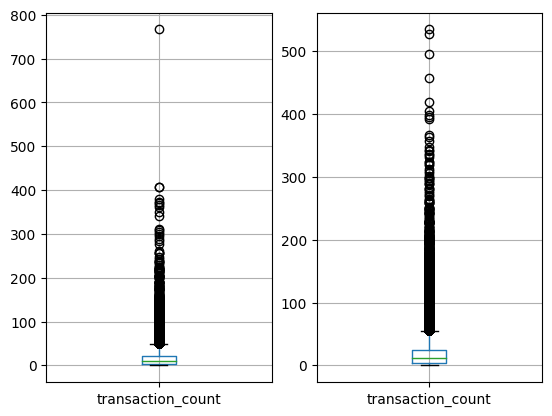

In [61]:
plt.subplot(1,2,1)
y_test.boxplot()
plt.subplot(1,2,2)
y_train.boxplot()

In [62]:
def metrics(y_pred,y_test,plot=True):
    y_pred=y_pred.ravel()
    y_test=y_test.values.ravel()
    mape=mean_absolute_percentage_error(y_test,y_pred)
    mae=mean_absolute_error(y_test,y_pred)
    mse=mean_squared_error(y_test,y_pred)
    print(f'Mean Absolute Percentage Error: {mape}')
    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Squared Error: {mse}')
    if plot:
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.hist(np.sqrt(np.abs(y_test-y_pred)))
        plt.title('Residuals Square Root')
        plt.subplot(1,3,2)
        plt.scatter(y_test,(y_test-y_pred),s=5,alpha=0.5)
        plt.xlabel('True values')
        plt.ylabel('Residuals')
        plt.tight_layout()
        plt.subplot(1,3,3)
        plt.scatter(y_test,y_pred,s=5,alpha=0.5)
        plt.xlabel('True values')
        plt.ylabel('predicted Values')
        plt.tight_layout()

### Linear Regression (elastic net)

In [63]:
Linear_elastic=ElasticNet()
Linear_elastic.fit(X_train,y_train)

ElasticNet()

Mean Absolute Percentage Error: 4096316794224102.5
Mean Absolute Error: 6.949209830822815
Mean Squared Error: 143.99681111314445


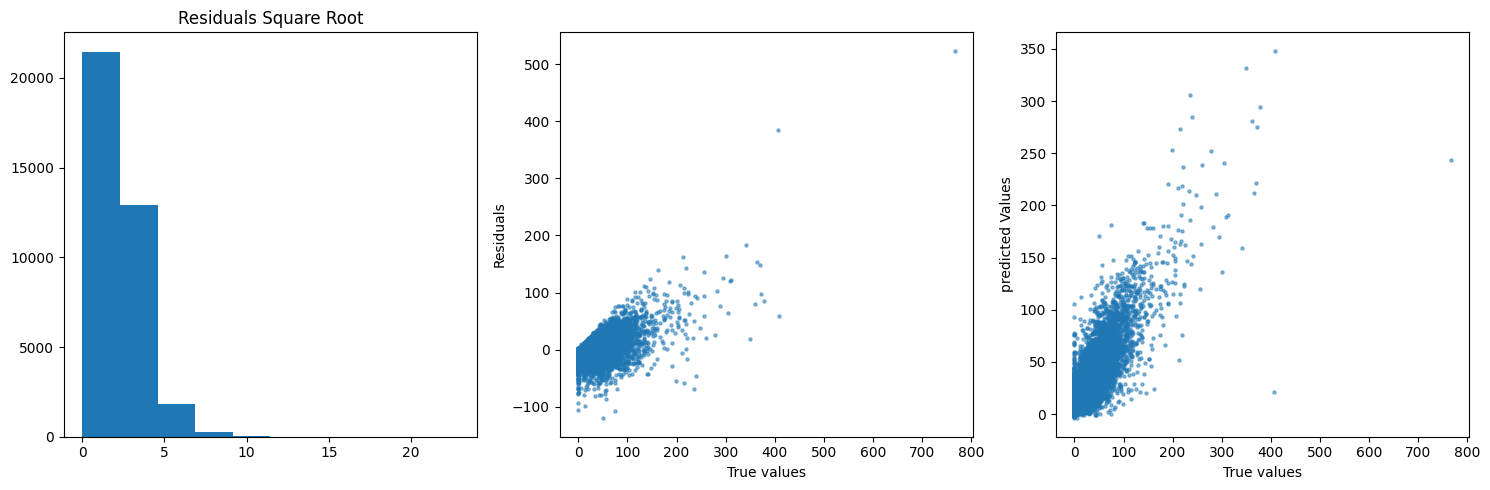

In [64]:
y_pred=Linear_elastic.predict(X_test)
metrics(y_pred,y_test,plot=True)

Text(0.5, 1.0, 'Elastic Net Coefficients')

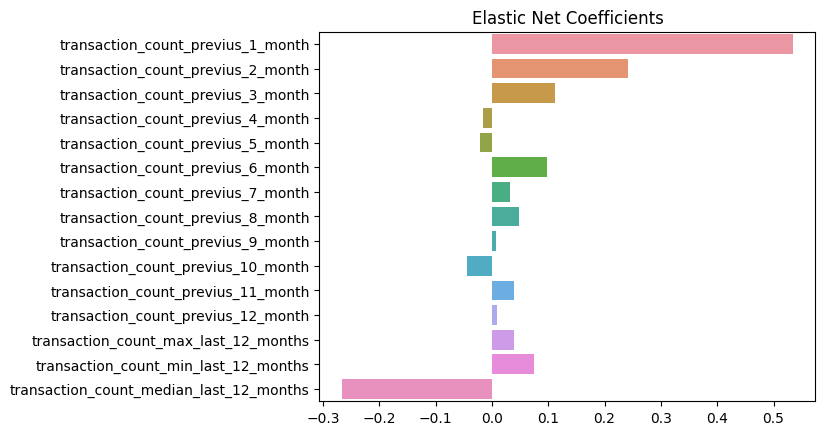

In [65]:
sns.barplot(x=Linear_elastic.coef_,y=X_features_count)
plt.title('Elastic Net Coefficients')

### Random Forest

In [66]:
RF=RandomForestRegressor(n_estimators=500)
RF.fit(X_train,y_train)
y_pred=RF.predict(X_test)


/tmp/ipykernel_2734224/2723155282.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_train,y_train)


Mean Absolute Percentage Error: 3620367884786563.0
Mean Absolute Error: 7.066705150353204
Mean Squared Error: 155.16730555352112


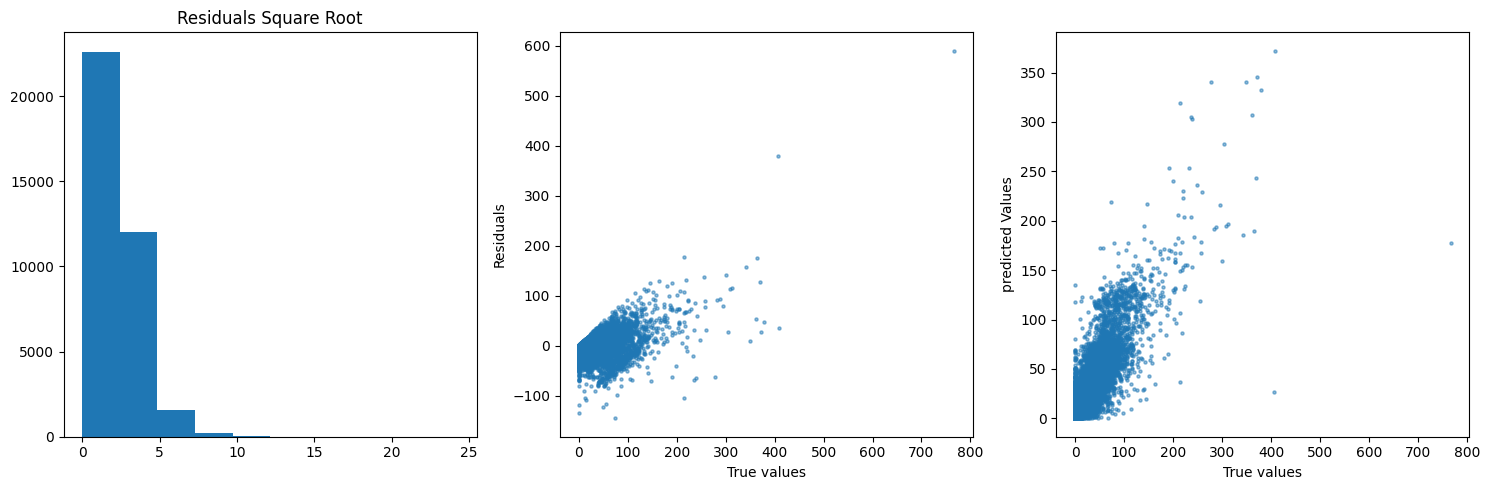

In [67]:
metrics(y_pred,y_test)

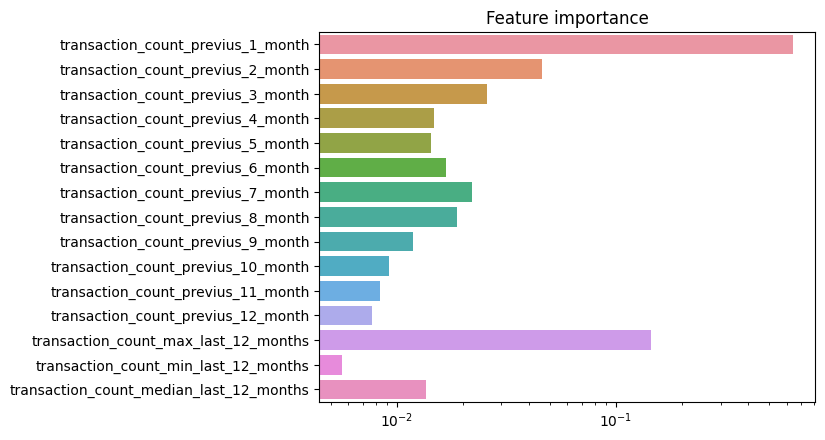

In [68]:
sns.barplot(y=X_features_count,x=RF.feature_importances_)
plt.title('Feature importance')
plt.xscale('log')

### KNN

In [69]:
KNN=KNeighborsRegressor(n_neighbors=5,weights='distance')
KNN.fit(X=X_train,y=y_train)


KNeighborsRegressor(weights='distance')

Mean Absolute Percentage Error: 3421607759598572.0
Mean Absolute Error: 7.0743742722160565
Mean Squared Error: 155.18207770672674


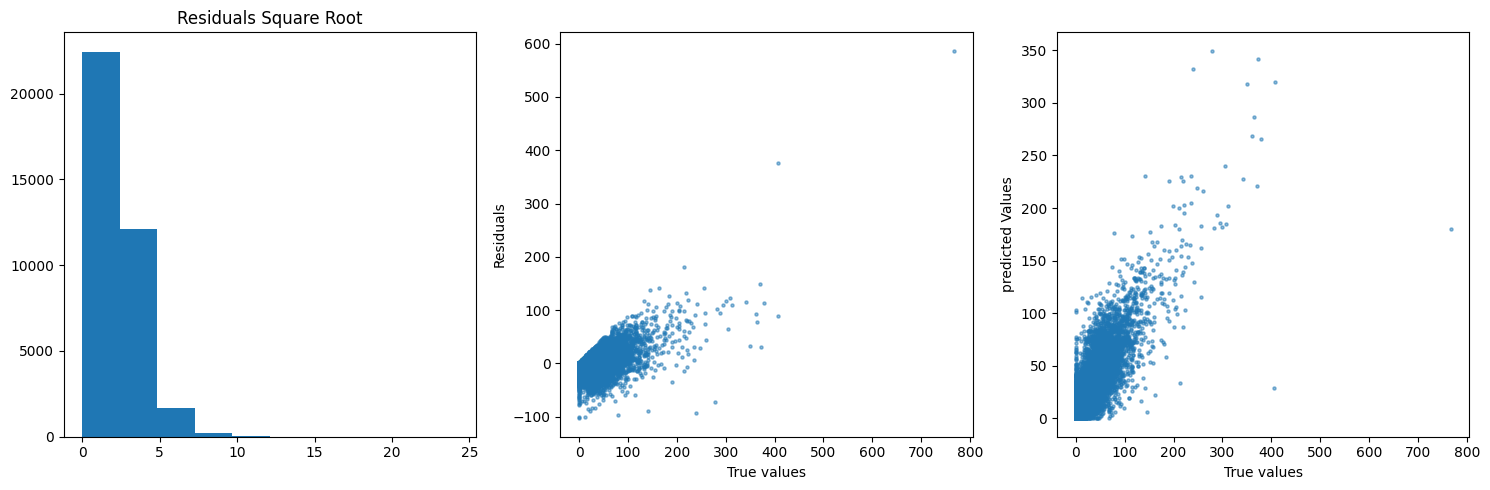

In [70]:
y_pred=KNN.predict(X_test)
metrics(y_pred,y_test,plot=True)

### Naive Bays

In [71]:
naive_bayes=GaussianNB()
naive_bayes.fit(X_train,y_train)


/home/estevanmendes/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

Mean Absolute Percentage Error: 4.991230248425534e+16
Mean Absolute Error: 56.95689371503784
Mean Squared Error: 10019.05731051881


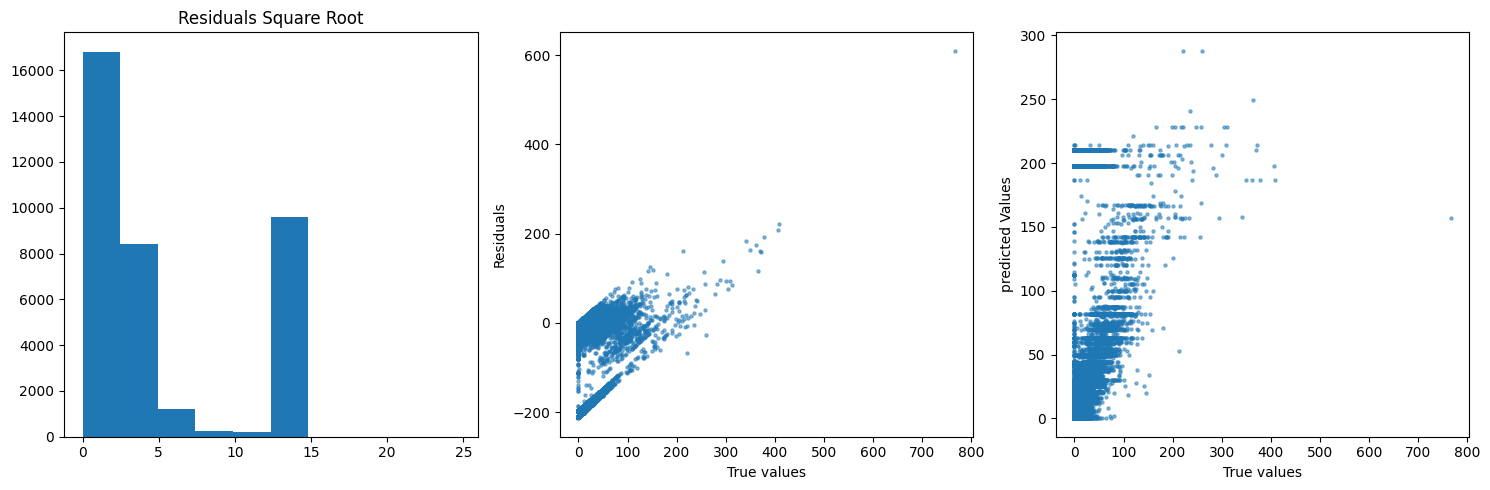

In [72]:
y_pred=naive_bayes.predict(X_test)
metrics(y_pred,y_test,plot=True)

### SVM

In [73]:
svm=SVR(kernel='rbf',max_iter=50000)
svm.fit(X_train,y_train)


/home/estevanmendes/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/estevanmendes/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVR(max_iter=50000)

Mean Absolute Percentage Error: 3587081076517378.5
Mean Absolute Error: 6.884363829538449
Mean Squared Error: 200.2217426589515


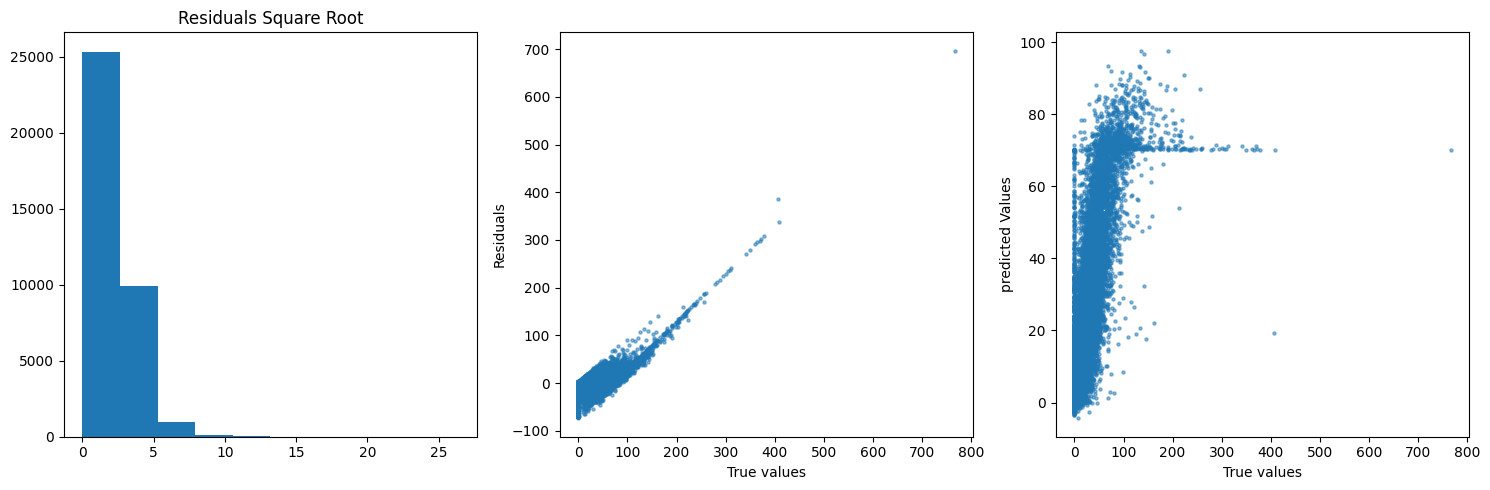

In [74]:
y_pred=svm.predict(X_test)
metrics(y_pred,y_test,plot=True)

### Genetic programing to solve the forecasting

In [75]:
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
import operator
import math
import random 

def protectedSigmoid(x):
    try:
        ans=math.exp(-x)
    except OverflowError:
        if x<0:
            return 0
        else:
            ans=0

    return 1 / (1 +ans )

def protectedDiv(left, right):
    try:
        ans=left / right
        if np.isnan(ans):
            return 0
        elif np.inf==ans:
            return 10**8
        elif -np.inf==ans:
            return -10**8
        else: 
            return ans
    except ZeroDivisionError:
        return 1

def square(x):
    return x**2




In [76]:
def predictions_fn(individual,X:pd.DataFrame):
    func = toolbox.compile(expr=individual)
    preds=X.apply(lambda x: func(*x),axis=1).to_list()
    
    return preds

def evaluation(individual,X,Y):
    
    preds=predictions_fn(individual,X)
    preds=np.array(preds)
    metric=mean_squared_error(Y,preds)
    return metric,



In [77]:
pset = gp.PrimitiveSet("MAIN", len(X_features_count))   # nome do procedimento a ser gerado e o número de argumentos
pset.addPrimitive(operator.add, 2)  # funções e o número de argumentos
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(square, 1)
pset.addPrimitive(math.sin, 1)
pset.addPrimitive(protectedSigmoid, 1)


In [78]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))                     # Minimização do erro
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)      # indivíduo

In [79]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=2, max_=8)                  # metade genfull (toda folha tem a mesma profundidade entre min e max) metade genGrow (folhas podem ter profundidades diferente entre min e max).
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [80]:
# operadores
from functools import partial

toolbox.register("evaluate", partial(evaluation,X=X_train,
                                                Y=y_train))                          # avaliação
toolbox.register("select", tools.selTournament, tournsize=3)      
toolbox.register("mate", gp.cxOnePointLeafBiased, termpb=0.1)                      # crossover    
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))     #limites para crossover
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))   # limites para mutação

In [81]:
from tqdm import tqdm

random.seed(1)  # Set the random seed for reproducibility
pop_size=100
gen=10
pop = toolbox.population(n=pop_size)
hof = tools.HallOfFame(1)

# Evaluate the entire population
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
prob_mutation=np.linspace(0.05,0.4,gen)
prob_crossover=np.linspace(0.5,0.1,gen)

logs=[]
for gen_index in tqdm(range(gen)):
     mutpb=prob_mutation[gen_index]
     cxpb=prob_crossover[gen_index]
     pop, log = algorithms.eaSimple(pop, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=1,  halloffame=hof, verbose=True,stats=stats)
     logs.append(log)
#pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=gen,  halloffame=hof, verbose=True,stats=stats)

  0%|          | 0/10 [00:00<?, ?it/s]/home/estevanmendes/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/home/estevanmendes/.local/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen	nevals	avg	std	min    	max
0  	100   	inf	nan	594.163	inf


 10%|█         | 1/10 [02:00<18:07, 120.83s/it]

1  	67    	1.97234e+17	1.94789e+18	594.163	1.95783e+19
gen	nevals	avg        	std        	min    	max        
0  	0     	1.97234e+17	1.94789e+18	594.163	1.95783e+19


 20%|██        | 2/10 [02:36<09:26, 70.84s/it] 

1  	51    	38223.7    	288490     	260.791	2.73164e+06
gen	nevals	avg    	std   	min    	max        
0  	0     	38223.7	288490	260.791	2.73164e+06


 30%|███       | 3/10 [03:10<06:17, 53.95s/it]

1  	52    	373974 	1.83516e+06	260.791	1.05932e+07
gen	nevals	avg   	std        	min    	max        
0  	0     	373974	1.83516e+06	260.791	1.05932e+07


 40%|████      | 4/10 [03:42<04:31, 45.17s/it]

1  	51    	1.37513e+92	1.36823e+93	260.791	1.37513e+94
gen	nevals	avg        	std        	min    	max        
0  	0     	1.37513e+92	1.36823e+93	260.791	1.37513e+94


 50%|█████     | 5/10 [04:16<03:26, 41.27s/it]

1  	52    	4.21689e+11	4.19562e+12	192.197	4.21676e+13
gen	nevals	avg        	std        	min    	max        
0  	0     	4.21689e+11	4.19562e+12	192.197	4.21676e+13


 60%|██████    | 6/10 [04:44<02:26, 36.57s/it]

1  	44    	2.85698e+16	2.84266e+17	192.197	2.85698e+18
gen	nevals	avg        	std        	min    	max        
0  	0     	2.85698e+16	2.84266e+17	192.197	2.85698e+18


 70%|███████   | 7/10 [05:09<01:38, 32.93s/it]

1  	47    	1.26357e+06	6.82367e+06	192.197	4.8873e+07 
gen	nevals	avg        	std        	min    	max       
0  	0     	1.26357e+06	6.82367e+06	192.197	4.8873e+07


 80%|████████  | 8/10 [05:30<00:58, 29.16s/it]

1  	44    	6.29127e+08	6.24754e+09	178.481	6.27914e+10
gen	nevals	avg        	std        	min    	max        
0  	0     	6.29127e+08	6.24754e+09	178.481	6.27914e+10


 90%|█████████ | 9/10 [05:49<00:25, 26.00s/it]

1  	39    	8.84942e+16	8.80501e+17	171.936	8.84937e+18
gen	nevals	avg        	std        	min    	max        
0  	0     	8.84942e+16	8.80501e+17	171.936	8.84937e+18


100%|██████████| 10/10 [06:10<00:00, 37.05s/it]

1  	41    	3.24429e+07	3.13029e+08	171.936	3.14677e+09


In [82]:
# Função encontrada
for i in hof:
  print(i)

mul(protectedSigmoid(protectedDiv(ARG12, ARG13)), ARG0)


In [83]:
evaluation(hof[0],X_train,y_train)

(171.93557925140564,)

In [84]:
import pygraphviz as pgv
import datetime

nodes, edges, labels = gp.graph(hof[0])
g = pgv.AGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]

g.draw(f'bestTree:{datetime.datetime.now()}.pdf')

/tmp/ipykernel_2734224/4219196556.py:6: RuntimeWarning: divide by zero encountered in divide
  percentage_absolute_error=100*np.abs(y_true-np.array(y_pred))/np.abs(y_true)
/tmp/ipykernel_2734224/4219196556.py:6: RuntimeWarning: invalid value encountered in divide
  percentage_absolute_error=100*np.abs(y_true-np.array(y_pred))/np.abs(y_true)


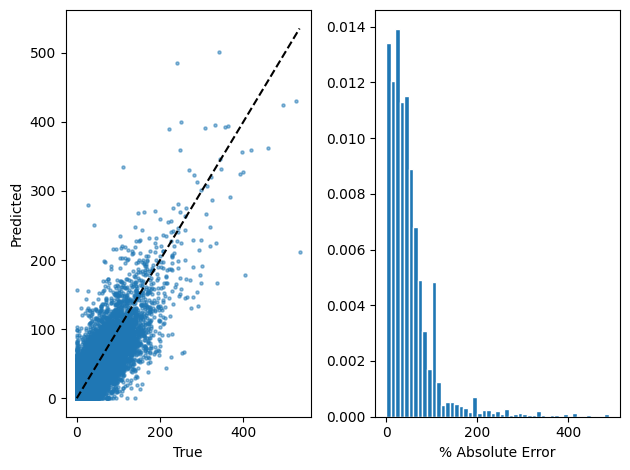

In [85]:
y_true,y_pred=y_train.values.squeeze(), predictions_fn(hof[0], X=X_train)
plt.subplot(121)
plt.scatter(y_true,y_pred,s=5,alpha=0.5)
plt.plot(np.linspace(0,y_true.max(),100),np.linspace(0,y_true.max(),100),color='black', linestyle='dashed')
pinf = float('+inf')
percentage_absolute_error=100*np.abs(y_true-np.array(y_pred))/np.abs(y_true)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.subplot(122)
plt.hist(percentage_absolute_error[percentage_absolute_error!=pinf],bins=np.arange(0,500,10),ec='white',density='True')
plt.xlabel('% Absolute Error')
plt.tight_layout()

/tmp/ipykernel_2734224/1075558176.py:7: RuntimeWarning: divide by zero encountered in divide
  percentage_absolute_error=100*np.abs(y_true-np.array(y_pred))/np.abs(y_true)
/tmp/ipykernel_2734224/1075558176.py:7: RuntimeWarning: invalid value encountered in divide
  percentage_absolute_error=100*np.abs(y_true-np.array(y_pred))/np.abs(y_true)


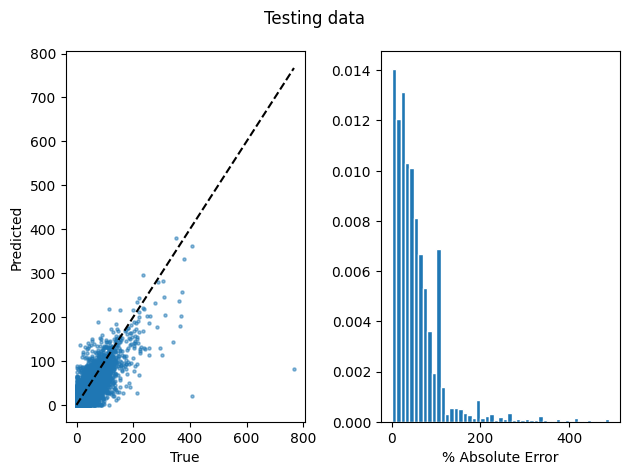

In [86]:
plt.suptitle('Testing data')
y_true,y_pred=y_test.values.squeeze(), predictions_fn(hof[0], X=X_test)
plt.subplot(121)
plt.scatter(y_true,y_pred,s=5,alpha=0.5)
plt.plot(np.linspace(0,y_true.max(),100),np.linspace(0,y_true.max(),100),color='black', linestyle='dashed')
pinf = float('+inf')
percentage_absolute_error=100*np.abs(y_true-np.array(y_pred))/np.abs(y_true)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.subplot(122)
plt.hist(percentage_absolute_error[percentage_absolute_error!=pinf],bins=np.arange(0,500,10),ec='white',density='True')
plt.xlabel('% Absolute Error')
plt.tight_layout()

Mean Absolute Percentage Error: 1950720170202131.5
Mean Absolute Error: 7.0404431985497675
Mean Squared Error: 174.7114795823954


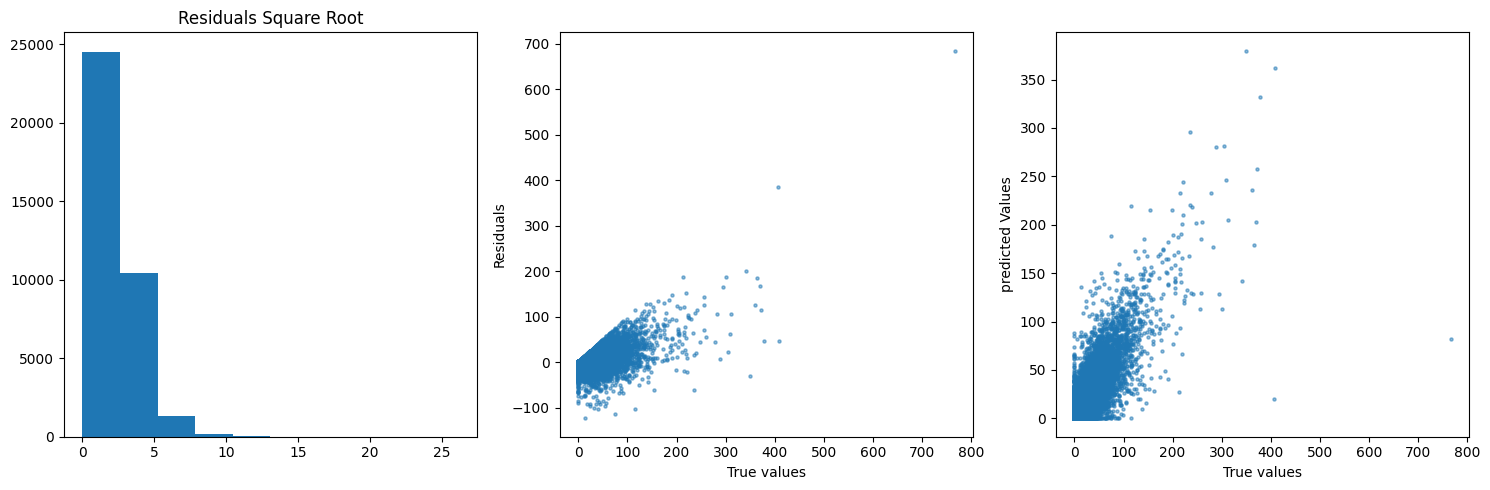

In [87]:
func = toolbox.compile(expr=hof[0])
y_pred=X_test.apply(lambda x: func(*x),axis=1).values
metrics(y_pred,y_test,plot=True)

### RNN

In [88]:
from tensorflow import keras


2024-12-02 14:53:21.130176: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 14:53:21.958486: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 14:53:24.069841: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [89]:
model = keras.Sequential()
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.GRU(128, return_sequences=True))
model.add(keras.layers.GRU(64,return_sequences=True))
model.add(keras.layers.GRU(32,return_sequences=True))
model.add(keras.layers.GRU(16,return_sequences=True))
model.add(keras.layers.GRU(16))

model.add(keras.layers.Dense(1))
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
model_loss=keras.losses.MeanSquaredError()
model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
model_metrics=[keras.metrics.MeanSquaredError(),keras.metrics.MeanAbsoluteError(),keras.metrics.MeanAbsolutePercentageError()]
model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)
model.build(input_shape=(None, X_train.shape[1],1))
model.summary()


2024-12-02 14:53:27.342390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-02 14:53:27.627868: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 15, 1)             4         
 Normalization)                                                  
                                                                 
 gru (GRU)                   (None, 15, 128)           50304     
                                                                 
 gru_1 (GRU)                 (None, 15, 64)            37248     
                                                                 
 gru_2 (GRU)                 (None, 15, 32)            9408      
                                                                 
 gru_3 (GRU)                 (None, 15, 16)            2400      
                                                                 
 gru_4 (GRU)                 (None, 16)                1632      
                                                        

In [90]:
epochs=10
batch_size=64
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
trainning_params={'callbacks':[callback,tensorboard_callback],'epochs':epochs,'batch_size':batch_size}  
    

In [91]:
history=model.fit(X_train.values.reshape(-1,X_train.shape[1],1),
                  y_train.values[...,np.newaxis],
                  validation_data=(X_test.values.reshape(-1,X_test.shape[1],1),y_test.values[...,np.newaxis]),
                  **trainning_params)

Epoch 1/10
1517/1517 [==============================] - 53s 30ms/step - loss: 583.1924 - mean_squared_error: 583.1924 - mean_absolute_error: 15.5527 - mean_absolute_percentage_error: 3495783936.0000 - val_loss: 526.1185 - val_mean_squared_error: 526.1185 - val_mean_absolute_error: 14.8374 - val_mean_absolute_percentage_error: 3726885120.0000
Epoch 2/10
1517/1517 [==============================] - 44s 29ms/step - loss: 579.3880 - mean_squared_error: 579.3880 - mean_absolute_error: 15.6138 - mean_absolute_percentage_error: 3586393344.0000 - val_loss: 527.5851 - val_mean_squared_error: 527.5851 - val_mean_absolute_error: 14.9971 - val_mean_absolute_percentage_error: 3811374080.0000
Epoch 3/10
1517/1517 [==============================] - 44s 29ms/step - loss: 464.7581 - mean_squared_error: 464.7581 - mean_absolute_error: 13.0140 - mean_absolute_percentage_error: 2575958016.0000 - val_loss: 232.8026 - val_mean_squared_error: 232.8026 - val_mean_absolute_error: 7.8382 - val_mean_absolute_per

1140/1140 [==============================] - 9s 7ms/step
Mean Absolute Percentage Error: 4641520532044899.0
Mean Absolute Error: 7.205393045254806
Mean Squared Error: 164.36530982000988


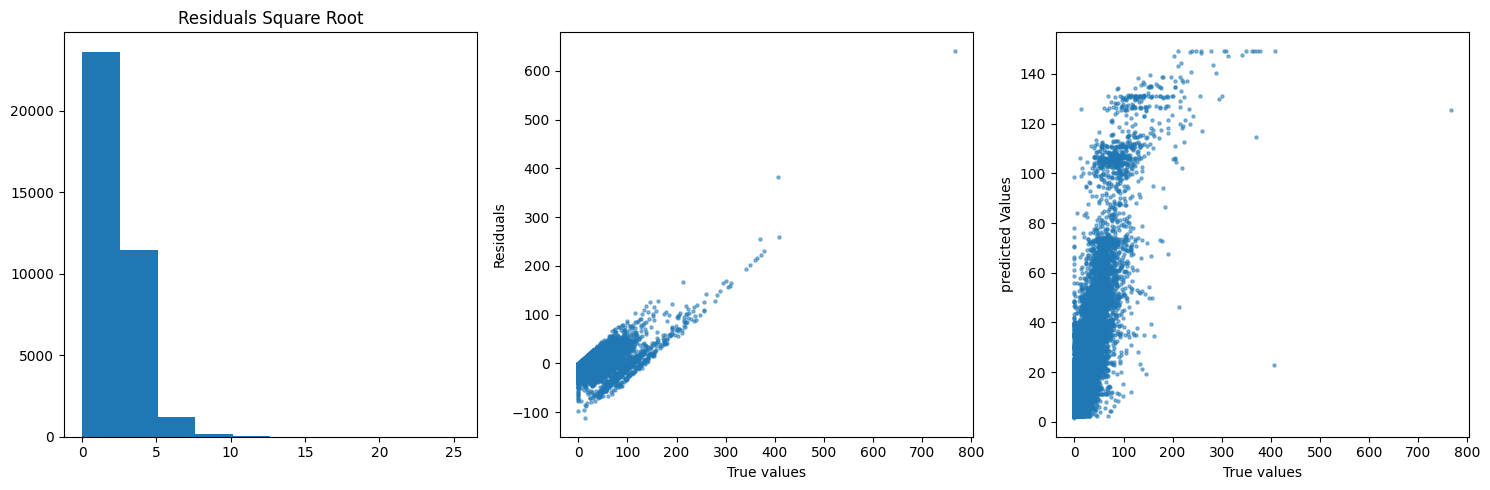

In [92]:
y_pred=model.predict(X_test.values.reshape(-1,X_test.shape[1],1)).squeeze()
metrics(y_pred,y_test,plot=True)

## Less than 3 orders in the last 12 months

In [93]:

X_train=df_trainning_less_than_3_orders[filter_previus_3_months][X_features_count]
y_train=df_trainning_less_than_3_orders[filter_previus_3_months][Y_features]
X_test=df_trainning_less_than_3_orders[filter_last_month][X_features_count]
y_test=df_trainning_less_than_3_orders[filter_last_month][Y_features]

/tmp/ipykernel_2734224/3842492854.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train=df_trainning_less_than_3_orders[filter_previus_3_months][X_features_count]
/tmp/ipykernel_2734224/3842492854.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_train=df_trainning_less_than_3_orders[filter_previus_3_months][Y_features]
/tmp/ipykernel_2734224/3842492854.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test=df_trainning_less_than_3_orders[filter_last_month][X_features_count]
/tmp/ipykernel_2734224/3842492854.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_test=df_trainning_less_than_3_orders[filter_last_month][Y_features]


In [94]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [95]:
Linear_elastic=ElasticNet()
Linear_elastic.fit(X_train,y_train)

ElasticNet()

Mean Absolute Percentage Error: 5245822297341408.0
Mean Absolute Error: 2.704951924874703
Mean Squared Error: 40.32743922298182


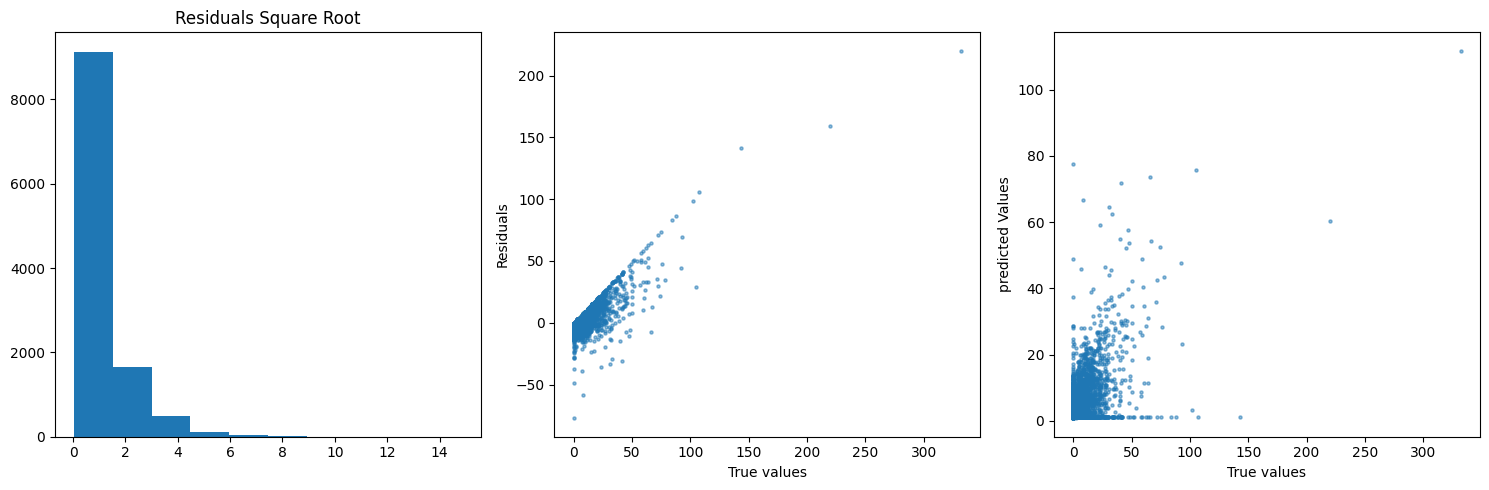

In [96]:
y_pred=Linear_elastic.predict(X_test)
metrics(y_pred,y_test,plot=True)

Text(0.5, 1.0, 'Elastic Net Coefficients')

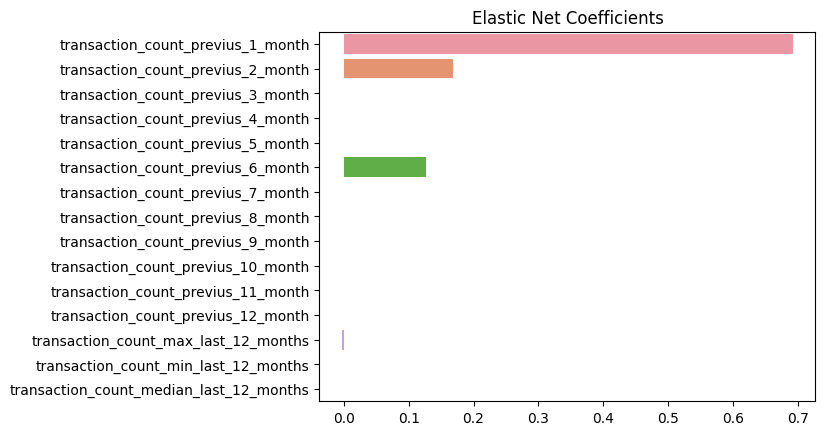

In [97]:
sns.barplot(x=Linear_elastic.coef_,y=X_features_count)
plt.title('Elastic Net Coefficients')

### Random Forest

In [98]:
RF=RandomForestRegressor(n_estimators=100)
RF.fit(X_train,y_train)
y_pred=RF.predict(X_test)


/tmp/ipykernel_2734224/1051490852.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_train,y_train)


Mean Absolute Percentage Error: 4304491072469179.5
Mean Absolute Error: 2.541215329111898
Mean Squared Error: 43.482577670189734


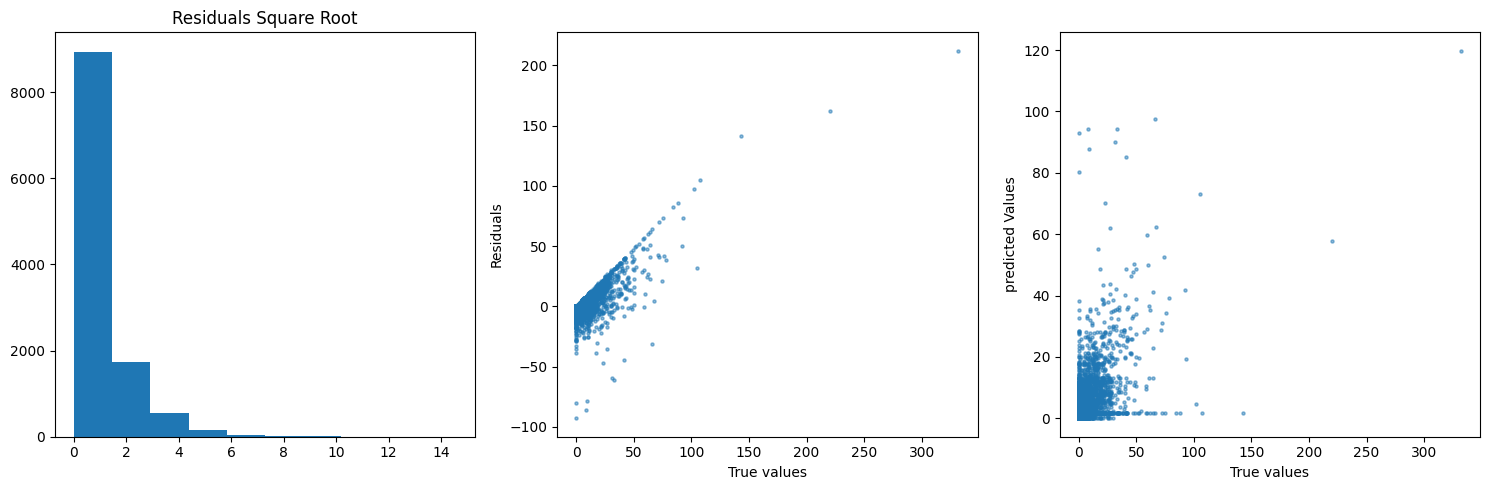

In [99]:
metrics(y_pred,y_test)

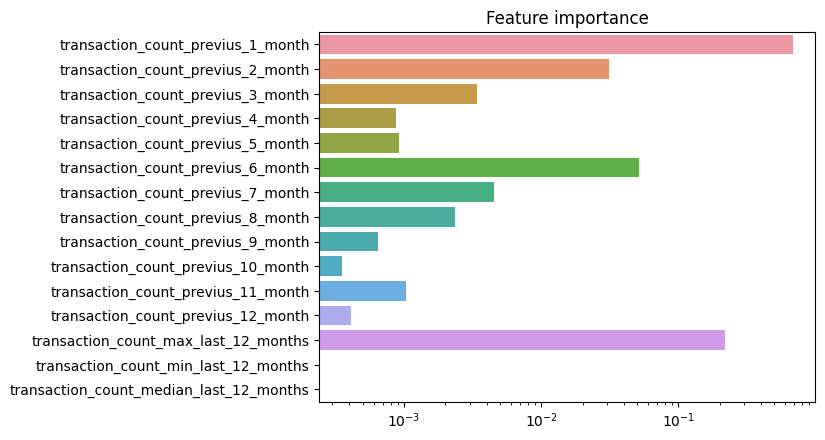

In [100]:
sns.barplot(y=X_features_count,x=RF.feature_importances_)
plt.title('Feature importance')
plt.xscale('log')

### KNN

In [101]:
KNN=KNeighborsRegressor(n_neighbors=5,weights='distance')
KNN.fit(X=X_train,y=y_train)


KNeighborsRegressor(weights='distance')

Mean Absolute Percentage Error: 3782869628277738.0
Mean Absolute Error: 2.510954506269031
Mean Squared Error: 44.2137966796386


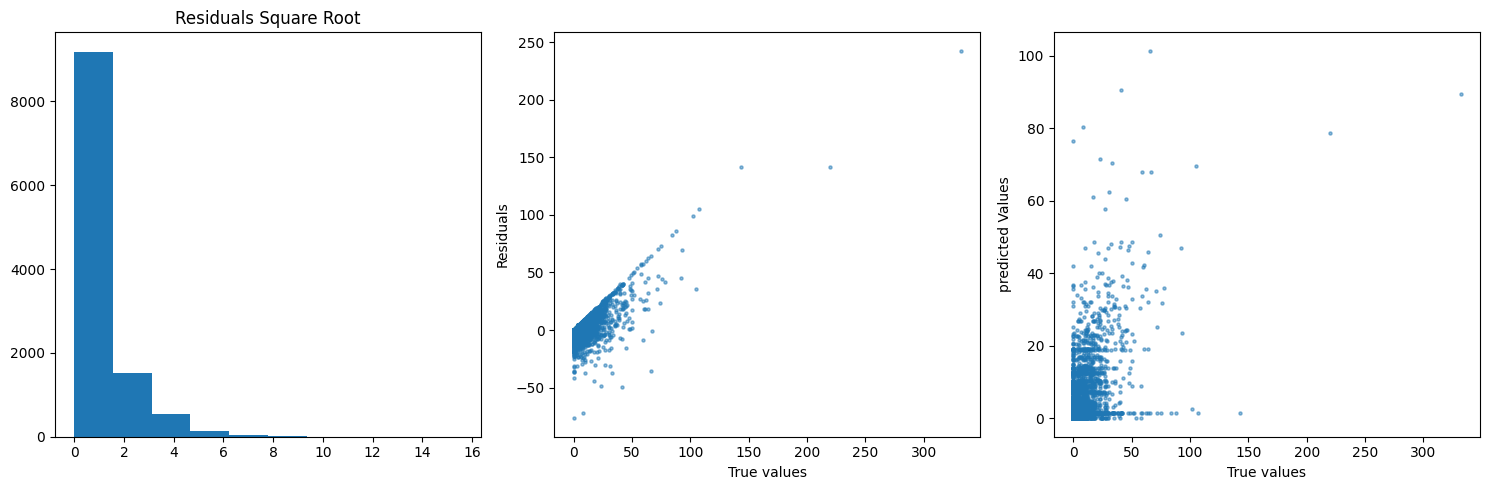

In [102]:
y_pred=KNN.predict(X_test)
metrics(y_pred,y_test,plot=True)

## Prediction

In [103]:
path_august_missing_orders='data_files_challenge/august_with_missing_order_days.parquet'
df_raw_august_missing_orders=pd.read_parquet(path_august_missing_orders)
df_raw_august_missing_orders.shape



(317735, 3)

In [104]:
df_august_missing_orders=df_raw_august_missing_orders.copy()
df_august_missing_orders['order_date']=pd.to_datetime(df_august_missing_orders['order_date'])
df_august_missing_orders['transaction_amount']=df_august_missing_orders['transaction_amount'].astype(float)
df_august_missing_orders['account_id']=df_august_missing_orders['account_id'].astype('category')

filter_negative_values=df_august_missing_orders['transaction_amount']<0
df_august_missing_orders.loc[filter_negative_values,'transaction_amount']=df_august_missing_orders.loc[filter_negative_values,'transaction_amount']*-1.

df_august_missing_orders['predicted_month']=pd.to_datetime('2021-08-01')
df_august_missing_orders['month']=pd.to_datetime('2021-08-01')

df_testing=df_august_missing_orders[['account_id','predicted_month','month']].drop_duplicates()


In [105]:
df_raw_historical_orders['account_id'].drop_duplicates().shape

(47899,)

In [106]:
df_trainning['account_id'].drop_duplicates().shape

(47899,)

In [107]:
df_testing.merge(df_trainning['account_id'].drop_duplicates(),on='account_id',how='inner').shape

(31721, 3)

In [108]:
df_testing.shape

(32944, 3)

In [109]:

df_testing=df_testing.merge(df_trainning, on=['account_id','month'],how='inner')

df_testing=df_testing.drop(columns=['transaction_count_median_last_12_months',
                         'transaction_sum_median_last_12_months',
                        'transaction_count_min_last_12_months',
                        'transaction_sum_min_last_12_months',
                        'transaction_count_max_last_12_months',
                        'transaction_sum_max_last_12_months'])

df_testing=df_testing.drop(columns=['transaction_count_previus_12_month',
                                    'transaction_sum_previus_12_month',
                                    'previus_12_month'])



In [110]:
df_testing.shape

(31721, 38)

In [111]:
columns_rename_map={}
for column in df_testing.columns[df_testing.columns.str.contains('previus')].to_list():
    index=column.split('_')[-2]
    index=int(index)
    index+=1
    columns_rename_map[column]='_'.join(column.split('_')[:-2])+'_'+str(index)+'_month'


columns_rename_map['transaction_count']='transaction_count_previus_1_month'
columns_rename_map['transaction_sum']='transaction_sum_previus_1_month'
columns_rename_map['month']='previus_1_month'
df_testing=df_testing.rename(columns=columns_rename_map)


In [112]:
filter_records_less_than_3_orders_last_12_months_test=df_testing[df_testing.columns[df_testing.columns.str.contains(r'transaction_count_')&\
                                                                (df_testing.columns!="transaction_count")]]\
                                                            .astype(bool).sum(axis=1)<=3





In [113]:
df_testing['transaction_sum_max_last_12_months'] = df_testing[[f'transaction_sum_previus_{offset}_month' for offset in range(1, 13)]].fillna(0).max(axis=1)
df_testing['transaction_sum_min_last_12_months'] = df_testing[[f'transaction_sum_previus_{offset}_month' for offset in range(1, 13)]].fillna(0).min(axis=1)
df_testing['transaction_sum_median_last_12_months'] = df_testing[[f'transaction_sum_previus_{offset}_month' for offset in range(1, 13)]].fillna(0).median(axis=1)

df_testing['transaction_count_max_last_12_months'] = df_testing[[f'transaction_count_previus_{offset}_month' for offset in range(1, 13)]].fillna(0).max(axis=1)
df_testing['transaction_count_min_last_12_months'] = df_testing[[f'transaction_count_previus_{offset}_month' for offset in range(1, 13)]].fillna(0).min(axis=1)
df_testing['transaction_count_median_last_12_months'] = df_testing[[f'transaction_count_previus_{offset}_month' for offset in range(1, 13)]].fillna(0).median(axis=1)


In [114]:
df_testing_more_than_3_orders=df_testing[~filter_records_less_than_3_orders_last_12_months_test]
df_testing_less_than_3_orders=df_testing[filter_records_less_than_3_orders_last_12_months_test]

In [115]:
X_test_more_than_3_orders=df_testing_more_than_3_orders[X_features_count]
X_test_less_than_3_orders=df_testing_less_than_3_orders[X_features_count]


Now lets train each model with the whole data so to produce august prediction

In [116]:
model_more_than_3_orders = ElasticNet()
model_more_than_3_orders.fit(df_trainning_more_than_3_orders[X_features_count], df_trainning_more_than_3_orders[Y_features])

ElasticNet()

In [117]:
model_less_than_3_orders = ElasticNet()
model_less_than_3_orders.fit(df_trainning_less_than_3_orders[X_features_count], df_trainning_less_than_3_orders[Y_features])

ElasticNet()

In [118]:
y_pred_more_than_3_orders=model_more_than_3_orders.predict(X_test_more_than_3_orders)

df_testing_more_than_3_orders['predicted_orders']=y_pred_more_than_3_orders

y_pred_less_than_3_orders=model_less_than_3_orders.predict(X_test_less_than_3_orders)
df_testing_less_than_3_orders['predicted_orders']=y_pred_less_than_3_orders

/tmp/ipykernel_2734224/2797812957.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testing_more_than_3_orders['predicted_orders']=y_pred_more_than_3_orders
/tmp/ipykernel_2734224/2797812957.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testing_less_than_3_orders['predicted_orders']=y_pred_less_than_3_orders


In [119]:
df_prediction=pd.concat([df_testing_less_than_3_orders[['account_id','predicted_orders']],
           df_testing_more_than_3_orders[['account_id','predicted_orders']]],axis=0).round(0)

To predict for clients who haven't ordered before, the median number of orders from clients in their first month will be used.

In [120]:
filter_first_month=df_trainning[df_trainning.columns[df_trainning.columns.str.contains(r'transaction_count_')&\
                                                                (df_trainning.columns!="transaction_count")]]\
                                                            .astype(bool).sum(axis=1)==0

filter_zero_orders=df_trainning['transaction_count']!=0
median_orders_first_month=df_trainning[filter_first_month&filter_zero_orders][['transaction_count']].median()

In [121]:
df_prediction_first_month=df_august_missing_orders[~df_august_missing_orders.account_id.isin(df_prediction.account_id)][['account_id']].drop_duplicates()
df_prediction_first_month['predicted_orders']=median_orders_first_month

In [122]:
df_prediction=pd.concat([df_prediction,df_prediction_first_month],axis=0)

In [123]:
df_prediction.head()

,account_id,predicted_orders
0,BR_09532176632,2.0
1,BR_58837817215,2.0
2,BR_66209644000100,2.0
3,BR_19114456000100,2.0
4,BR_04185749287,2.0


In [124]:
df_prediction.shape

(32944, 2)

In [ ]:
df_prediction.to_csv('august_prediction.csv')

# Question 2

In [126]:
df_orders=df_trainning[['account_id','month','transaction_count']]

In [127]:
df_total_orders=df_orders.groupby('account_id').sum().reset_index().rename(columns={'transaction_count':'total_orders'})
df_orders=df_orders.merge(df_total_orders)

/tmp/ipykernel_2734224/1646632657.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_total_orders=df_orders.groupby('account_id').sum().reset_index().rename(columns={'transaction_count':'total_orders'})


Split customers into deciles based on their total order count.

In [128]:
df_orders['decile']=pd.qcut(df_orders['total_orders'],10,labels=False)

<Axes: xlabel='total_orders', ylabel='Count'>

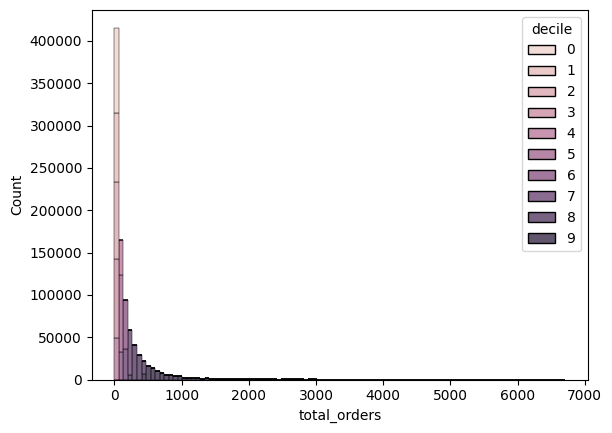

In [129]:
sns.histplot(df_orders,x='total_orders',hue='decile',multiple='stack',bins=100)

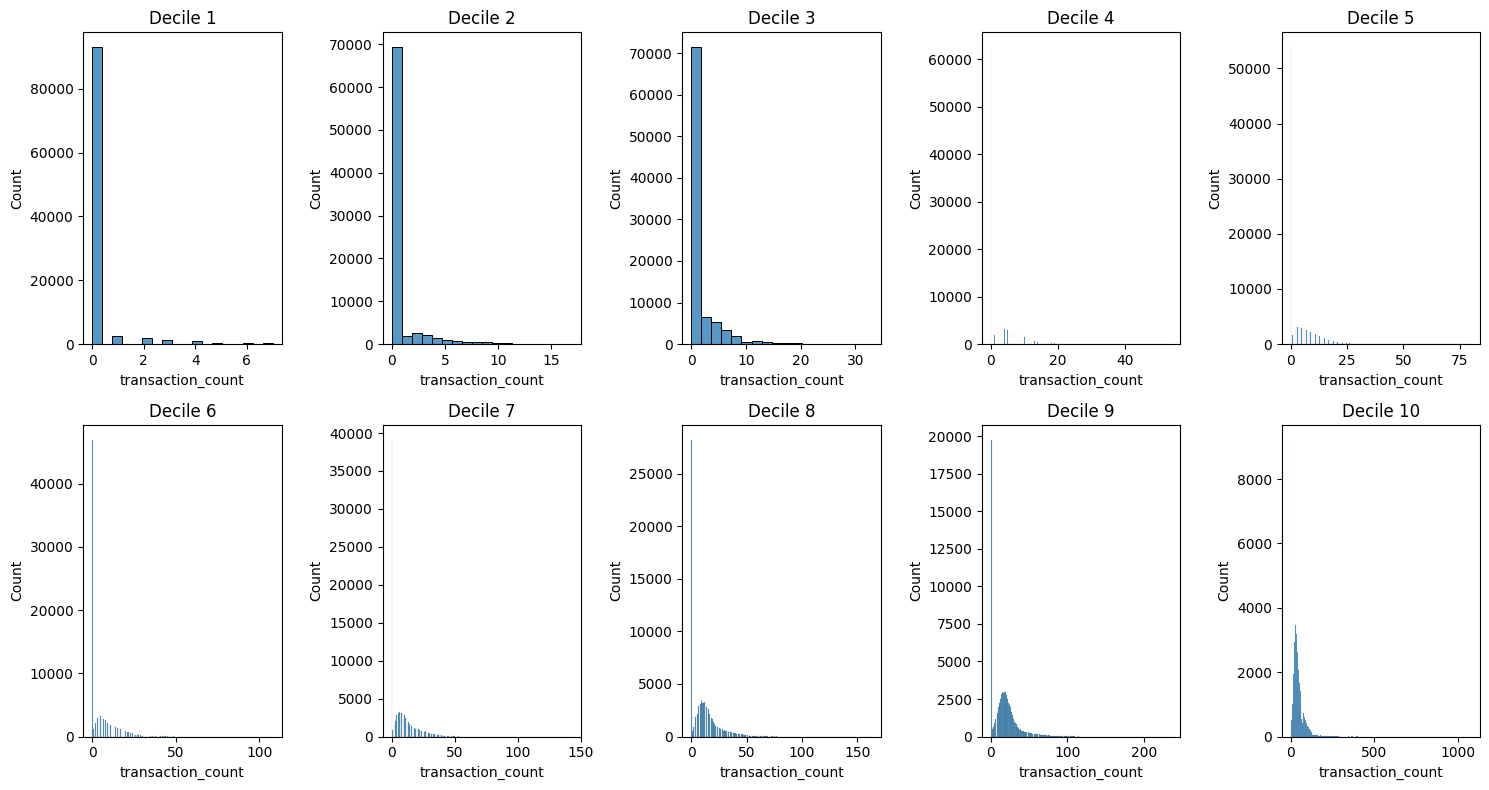

In [130]:
fig,axs=plt.subplots(2,5,figsize=(15,8))
for i in range(10):
    sns.histplot(df_orders[df_orders['decile']==i]['transaction_count'],ax=axs[i//5,i%5])
    axs[i//5,i%5].set_title(f'Decile {i+1}')
plt.tight_layout()

We will focus on decile 9

MLE

In [131]:
import scipy.stats as stats 


In [132]:
df_orders_decile_9=df_orders[df_orders['decile']==8]

In [133]:
df_orders_decile_9['transaction_count'].describe()

count    90877.000000
mean        17.953035
std         16.502770
min          0.000000
25%          5.000000
50%         16.000000
75%         25.000000
max        236.000000
Name: transaction_count, dtype: float64

In [134]:
df_orders_decile_9=df_orders_decile_9[df_orders_decile_9['transaction_count']>0]

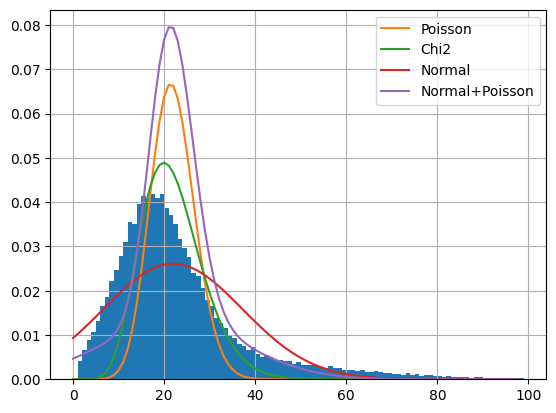

In [135]:
df_orders_decile_9['transaction_count'].hist(bins=np.arange(1,100,1),density=True)
sample_mean=df_orders_decile_9['transaction_count'].mean()
sample_std=df_orders_decile_9['transaction_count'].std()

poisson=.8*stats.poisson.pmf(np.arange(1,100,1),sample_mean)
chi2=.8*stats.chi2.pdf(np.arange(1,100,1),sample_mean)  
normal=stats.norm.pdf(np.arange(1,100,1),sample_mean,sample_std)
plt.plot(poisson,label='Poisson')
plt.plot(chi2,label='Chi2')
plt.plot(normal,label='Normal')
plt.plot(.5*normal+poisson,label='Normal+Poisson') 

plt.legend()

In [136]:
from statsmodels.discrete.discrete_model import Poisson

The maximum likelihood estimate (MLE) of the Poisson probability density function (pdf) is achieved when the parameter λ (lambda) is equal to the sample mean.



In [137]:
lambda_parameter=df_orders_decile_9['transaction_count'].mean()

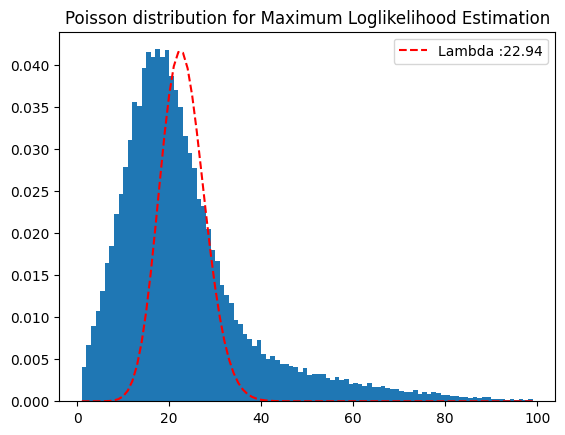

In [138]:

(freqs,bins,_)=plt.hist(df_orders_decile_9['transaction_count'],bins=np.arange(1,100,1),density=True)
poisson_MLE_points=stats.poisson.pmf(bins,lambda_parameter)

plt.plot(bins,0.5*poisson_MLE_points,color='red',label=f'Lambda :{lambda_parameter:.2f}',linestyle='dashed')
plt.title('Poisson distribution for Maximum Loglikelihood Estimation')
plt.legend()

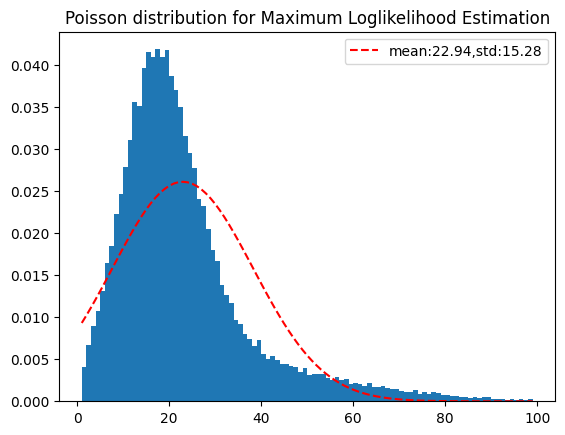

In [139]:
loc=np.mean(df_orders_decile_9['transaction_count'])
scale=np.std(df_orders_decile_9['transaction_count'])


(freqs,bins,_)=plt.hist(df_orders_decile_9['transaction_count'],bins=np.arange(1,100,1),density=True)
gaussian_MLE_points=stats.norm.pdf(bins,loc=loc,scale=scale)

plt.plot(bins,gaussian_MLE_points,color='red',label=f'mean:{loc:.2f},std:{scale:.2f}',linestyle='dashed')
plt.title('Poisson distribution for Maximum Loglikelihood Estimation')
plt.legend()

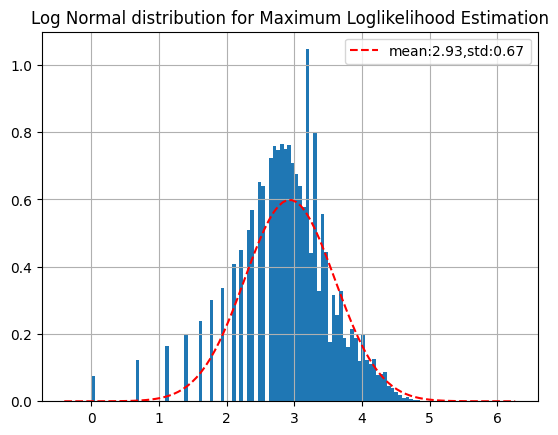

In [140]:
df_orders_decile_9['transaction_count'].apply(lambda x: np.log(x)).hist(bins=100,density=True)

mu=np.mean(df_orders_decile_9['transaction_count'].apply(lambda x: np.log(x)))
sigma=np.std(df_orders_decile_9['transaction_count'].apply(lambda x: np.log(x)))
x=np.linspace(mu-5*sigma,mu+5*sigma,100)
plt.plot(x,stats.norm.pdf(x,loc=mu,scale=sigma),color='red',label=f'mean:{mu:.2f},std:{sigma:.2f}',linestyle='dashed')
plt.title('Log Normal distribution for Maximum Loglikelihood Estimation')
plt.legend()


Since using MLE is not providing a good fit for the data, lest use the minimization of error to fit the distribution to some function.

In [141]:
from lmfit import Model

In [142]:
def poisson(x,lambda_parameter,scaler):
    return scaler*stats.poisson.pmf(x,lambda_parameter) 

In [143]:
model=Model(poisson)
result=model.fit(freqs,x=bins[:-1],lambda_parameter=lambda_parameter,scaler=0.5)
result

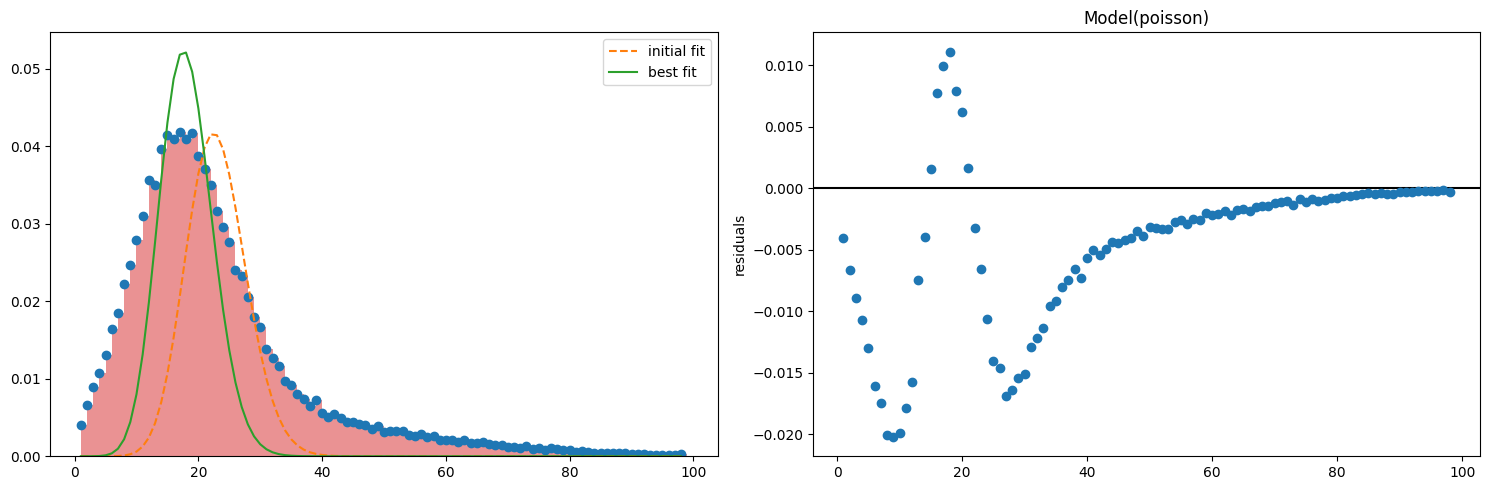

In [144]:
def plot_results(result):
    fig,axs=plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(bins[:-1], freqs, 'o')
    axs[0].plot(bins[:-1], result.init_fit, '--', label='initial fit')
    axs[0].plot(bins[:-1], result.best_fit, '-', label='best fit')
    axs[0].hist(df_orders_decile_9['transaction_count'],bins=np.arange(1,100,1),density=True,alpha=0.5)
    axs[0].legend()
    result.plot_residuals(ax=axs[1])
    plt.tight_layout()

plot_results(result)


In [145]:
def log_normal(x,mu,sigma,scaler):
    return scaler*stats.norm.pdf(np.log(x+1),loc=mu,scale=sigma)

In [146]:
model=Model(log_normal)
result=model.fit(freqs,x=bins[:-1],mu=1,sigma=1,scaler=0.5)
result

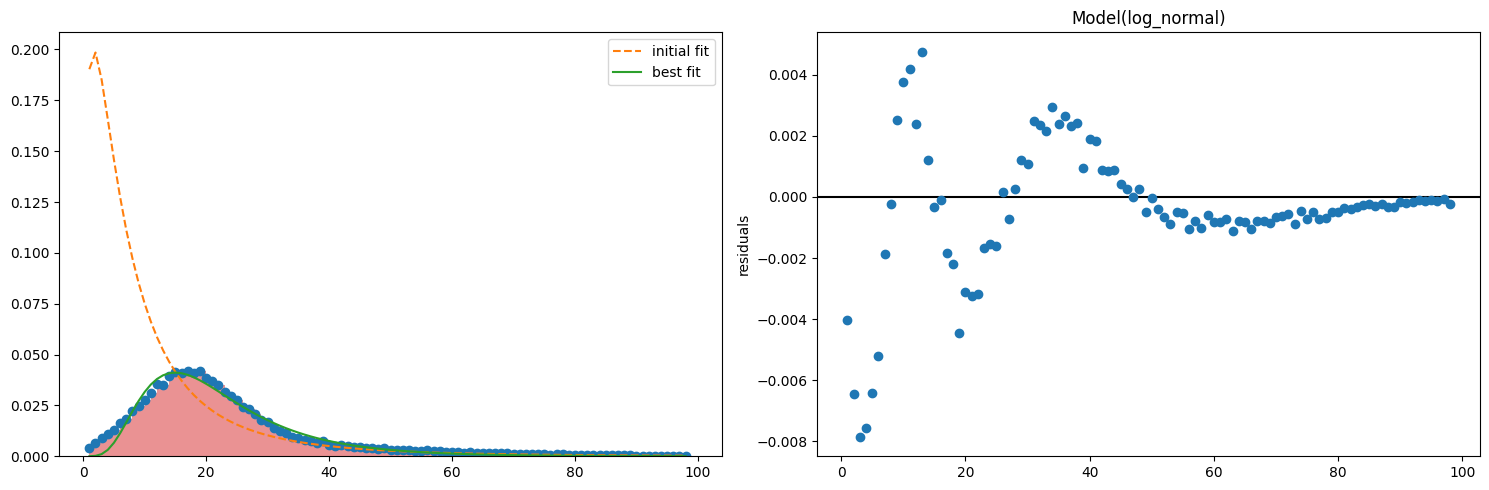

In [147]:
plot_results(result)


In [148]:
def normal_and_poisson(x,mu,sigma,lambda_parameter,scaler_a,scaler_b):
    return scaler_a*(stats.norm.pdf(x,loc=mu,scale=sigma)+scaler_b*stats.poisson.pmf(x,lambda_parameter))

In [149]:
model=Model(normal_and_poisson)
result=model.fit(freqs,x=bins[:-1],mu=sample_mean,sigma=sample_std,lambda_parameter=sample_mean,scaler_a=0.5,scaler_b=0.5)
result

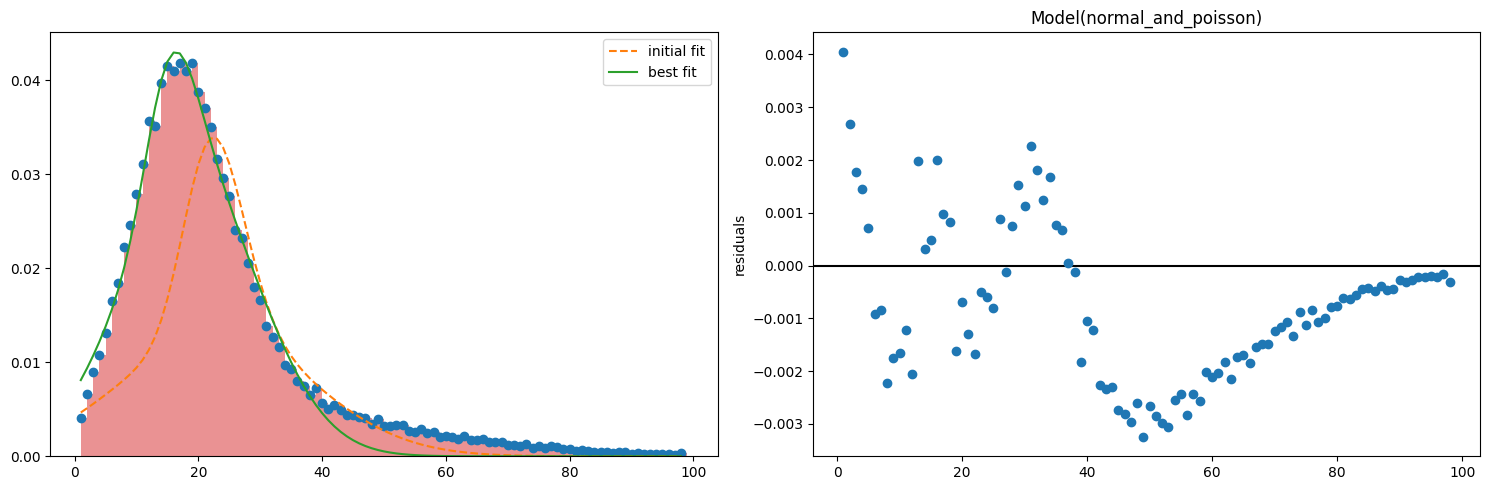

In [150]:
plot_results(result)


The fit appears to be satisfactory based on visual inspection, the Akaike Information Criterion (AIC), and the R-squared value. It provides the best adjustment among the models considered.

In [151]:
params={'mu': 18.745222861116428,
 'sigma': 10.972009058081227,
 'lambda_parameter': 16.22240383843186,
 'scaler_a': 0.8236482399021352,
 'scaler_b': 0.17040997498503402}

In [152]:
def best_model(x):
    return normal_and_poisson(x,**params)

In [153]:
More_than_4_orders=1-sum(best_model(i) for i in range(1,5))
print('the probability of having more than 4 orders is:',More_than_4_orders)

the probability of having more than 4 orders is: 0.9596754156694149


## 2.d

In [154]:
costumers=df_orders_decile_9.account_id.to_list()

In [155]:
len(costumers)

71116

In [156]:
df_historical_orders.head()

,account_id,order_date,transaction_amount,month
0,BR_09607801000194,2021-08-28,11011.2,2021-08-01
1,BR_09607801000194,2021-08-28,13764.0,2021-08-01
2,BR_09607801000194,2021-08-28,11011.2,2021-08-01
3,BR_09607801000194,2021-08-28,11011.2,2021-08-01
4,BR_09607801000194,2021-08-28,13764.0,2021-08-01


In [157]:
df_costumers_orders_days=df_historical_orders[df_historical_orders.account_id.isin(costumers)][['account_id','order_date']].drop_duplicates()

In [158]:
dfs=[]
for costumer in costumers:

    dfs.append(df_costumers_orders_days[df_costumers_orders_days.account_id==costumer]\
               .sort_values('order_date')[['order_date']]\
               .diff())

df_time_between_orders=pd.concat(dfs,axis=0).dropna()

In [159]:
df_time_between_orders['order_date'].dt.days.describe()

count    4.538723e+06
mean     7.962676e+00
std      8.092525e+00
min      1.000000e+00
25%      4.000000e+00
50%      7.000000e+00
75%      8.000000e+00
max      3.410000e+02
Name: order_date, dtype: float64

In [160]:
quantile_99=df_time_between_orders['order_date'].dt.days.quantile(0.99)
quantile_99

35.0

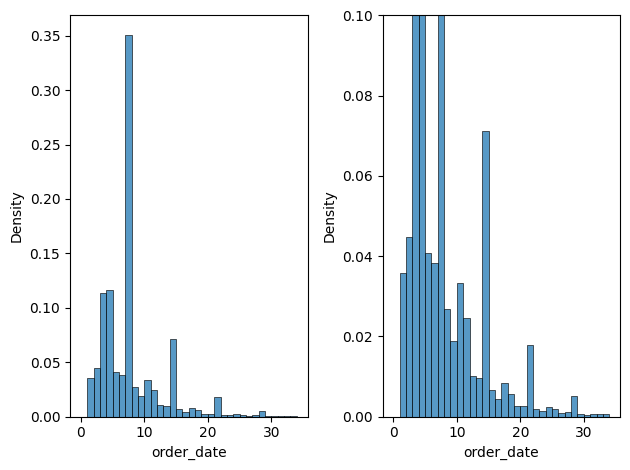

In [175]:
plt.subplot(1,2,1)
sns.histplot(x=df_time_between_orders['order_date'].dt.days,bins=np.arange(0,quantile_99,1),stat = 'density')
plt.subplot(1,2,2)
sns.histplot(x=df_time_between_orders['order_date'].dt.days,bins=np.arange(0,quantile_99,1),stat = 'density')
plt.ylim(0,0.1)
plt.tight_layout()

In [162]:
freqs,bins=np.histogram(df_time_between_orders['order_date'].dt.days,bins=np.arange(0,quantile_99,1),density=True)

In [163]:
def proposed_formula_poisson(x, amp_4, amp_5, amp_7, amp_14, amp_21, scaler):
    y = []
    for value in x:
        if value == 4:
            y.append(amp_4 + poisson(value, lambda_parameter, scaler))
        elif value == 5:
            y.append(amp_5 + poisson(value, lambda_parameter, scaler))
        elif value == 7:
            y.append(amp_7 + poisson(value, lambda_parameter, scaler))
        elif value == 14:
            y.append(amp_14 + poisson(value, lambda_parameter, scaler))
        elif value == 21:
            y.append(amp_21 + poisson(value, lambda_parameter, scaler))
        else:
            y.append(poisson(value, lambda_parameter, scaler))
    return y


In [164]:
model=Model(proposed_formula_poisson)
result=model.fit(freqs,x=bins[:-1],amp_4=0.1,amp_5=0.1,amp_7=0.2,amp_14=0.1,amp_21=0.1,scaler=0.5)
result

In [165]:
def plot_result_custom(result):
    fig,axs=plt.subplots(1,2,figsize=(15,5))
    freqs,bins=np.histogram(df_time_between_orders['order_date'].dt.days,bins=np.arange(0,quantile_99,1),density=True)
    axs[0].plot(bins[:-1], freqs, 'o')
    axs[0].plot(bins[:-1], result.best_fit, '-', label='best fit')
    axs[0].hist(df_time_between_orders['order_date'].dt.days,bins=np.arange(0,quantile_99,1),density=True,alpha=0.5)
    axs[0].legend()
    result.plot_residuals(ax=axs[1])
    plt.tight_layout()
    

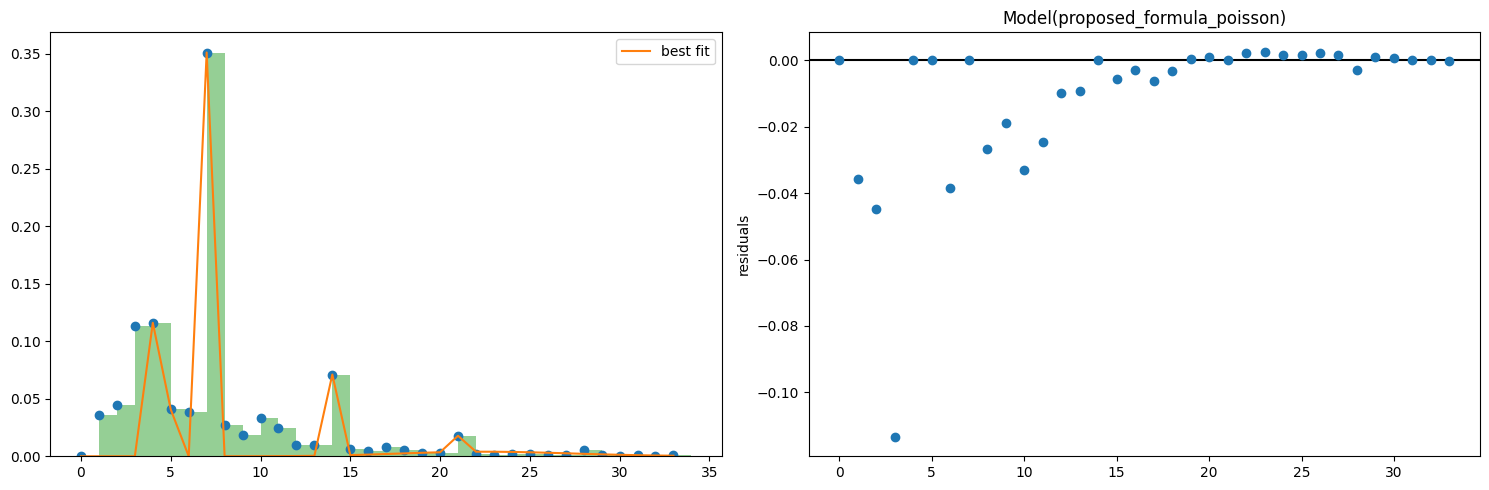

In [166]:
plot_result_custom(result)

In [167]:
def proposed_formula_norm(x, scaler_1,mu_1,sigma_1,
                             scaler_2,mu_2,sigma_2,
                             scaler_3,mu_3,sigma_3,
                             scaler_4,mu_4,sigma_4):
    y=scaler_1*stats.norm.pdf(x,loc=mu_1,scale=sigma_1)+\
    scaler_2*stats.norm.pdf(x,loc=mu_2,scale=sigma_2)+\
    scaler_3*stats.norm.pdf(x,loc=mu_3,scale=sigma_3)+\
    scaler_4*stats.norm.pdf(x,loc=mu_4,scale=sigma_4)
    if np.isnan(y).any():
        return np.zeros_like(x)
    return y


In [168]:
proposed_formula_norm(bins,0.1,1,1,0.1,1,1,0.1,1,1,0.1,1,1)

array([9.67882898e-002, 1.59576912e-001, 9.67882898e-002, 2.15963866e-002,
       1.77273936e-003, 5.35320903e-005, 5.94687806e-007, 2.43035314e-009,
       3.65388816e-012, 2.02090843e-015, 4.11190943e-019, 3.07783945e-023,
       8.47527701e-028, 8.58553494e-033, 3.19953110e-038, 4.38642624e-044,
       2.21228382e-050, 4.10465229e-057, 2.80167285e-064, 7.03499817e-072,
       6.49854415e-080, 2.20837934e-088, 2.76081177e-097, 1.26971262e-106,
       2.14822415e-116, 1.33708578e-126, 3.06157189e-137, 2.57890399e-148,
       7.99155704e-160, 9.11030991e-172, 3.82067782e-184, 5.89458454e-197,
       3.34558064e-210, 6.98546503e-224, 5.36567867e-238])

In [169]:
model=Model(proposed_formula_norm)
result=model.fit(freqs,x=bins[:-1],mu_1=5,mu_2=7,mu_3=14,mu_4=21,scaler_1=0.1,scaler_2=0.1,scaler_3=0.1,scaler_4=0.1,sigma_1=1,sigma_2=1,sigma_3=1,sigma_4=1,)
result

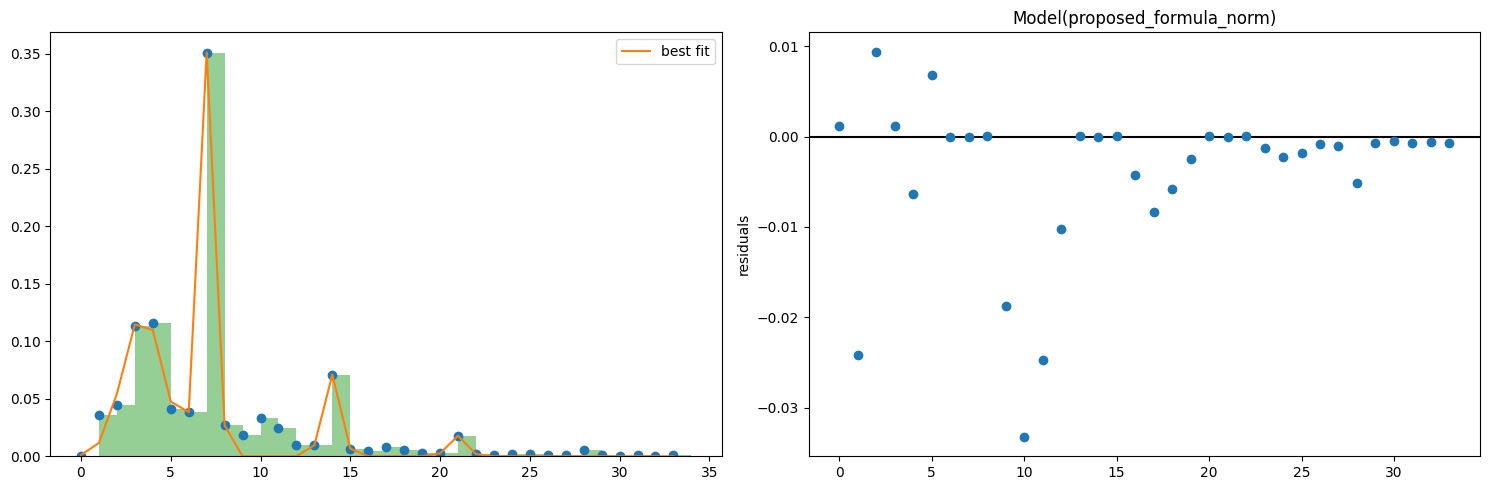

In [170]:
plot_result_custom(result)

### (Best Model) Inspecting the days between orders, acknowledging the weekly cycle

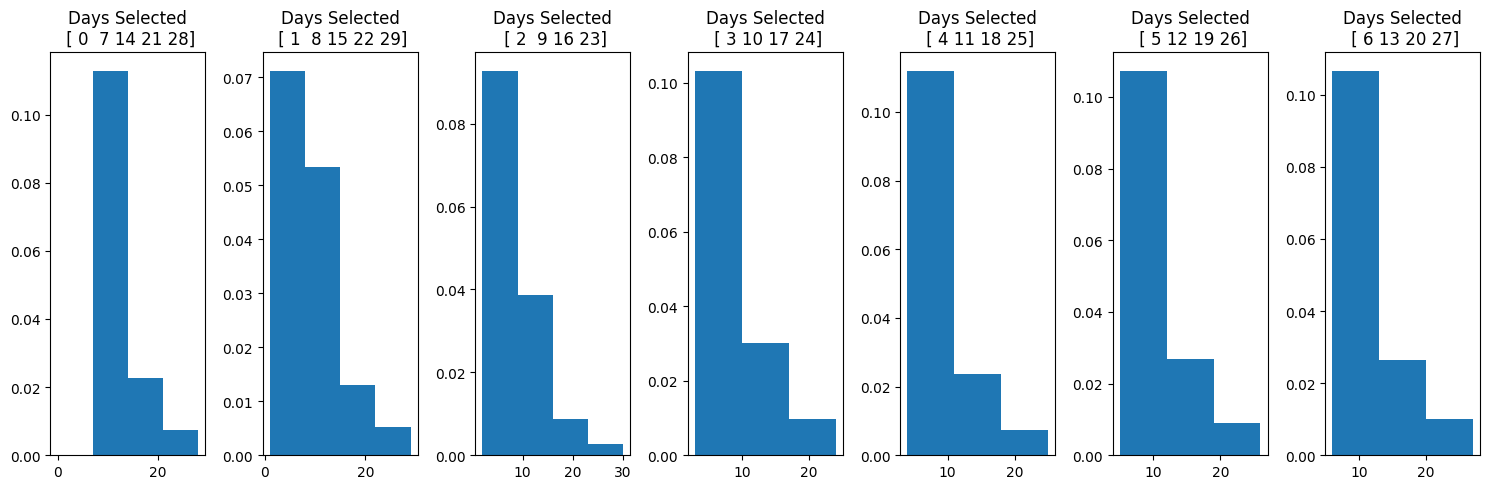

In [171]:
fig,axs=plt.subplots(1,7,figsize=(15,5))
for start_day in range(0,7):
    axs[start_day].hist(df_time_between_orders['order_date'].dt.days[df_time_between_orders['order_date'].dt.days.isin(np.arange(start_day,30,step=7))],
             bins=np.arange(start_day,31,step=7),
             density=True
             )
    axs[start_day].set_title(f'Days Selected\n {np.arange(start_day,30,step=7)}')
plt.tight_layout()

In [172]:
def proposed_formula_poisson_weekly(x,scaler_1,lambda_1,
                                   scaler_2,lambda_2,
                                   scaler_3,lambda_3,
                                   scaler_4,lambda_4,
                                   scaler_5,lambda_5,
                                   scaler_6,lambda_6,
                                   scaler_7,lambda_7):
    y = np.zeros_like(x, dtype=float)
    y[x % 7 == 0] = scaler_1 * stats.poisson.pmf(x[x % 7 == 0], lambda_1)
    y[x % 7 == 1] = scaler_2 * stats.poisson.pmf(x[x % 7 == 1], lambda_2)
    y[x % 7 == 2] = scaler_3 * stats.poisson.pmf(x[x % 7 == 2], lambda_3)
    y[x % 7 == 3] = scaler_4 * stats.poisson.pmf(x[x % 7 == 3], lambda_4)
    y[x % 7 == 4] = scaler_5 * stats.poisson.pmf(x[x % 7 == 4], lambda_5)
    y[x % 7 == 5] = scaler_6 * stats.poisson.pmf(x[x % 7 == 5], lambda_6)
    y[x % 7 == 6] = scaler_7 * stats.poisson.pmf(x[x % 7 == 6], lambda_7)
    if any(np.isnan(y)):
        return np.zeros_like(x)

    return y




In [173]:
model=Model(proposed_formula_poisson_weekly)
initial_guess={
"lambda_1":df_time_between_orders['order_date'].dt.days[df_time_between_orders['order_date'].dt.days.isin(np.arange(0,30,step=7))].mean(),
 "lambda_2":df_time_between_orders['order_date'].dt.days[df_time_between_orders['order_date'].dt.days.isin(np.arange(1,30,step=7))].mean(),
 "lambda_3":df_time_between_orders['order_date'].dt.days[df_time_between_orders['order_date'].dt.days.isin(np.arange(2,30,step=7))].mean(),
 "lambda_4":df_time_between_orders['order_date'].dt.days[df_time_between_orders['order_date'].dt.days.isin(np.arange(3,30,step=7))].mean(),
 "lambda_5":df_time_between_orders['order_date'].dt.days[df_time_between_orders['order_date'].dt.days.isin(np.arange(4,30,step=7))].mean(),
 "lambda_6":df_time_between_orders['order_date'].dt.days[df_time_between_orders['order_date'].dt.days.isin(np.arange(5,30,step=7))].mean(),
 "lambda_7":df_time_between_orders['order_date'].dt.days[df_time_between_orders['order_date'].dt.days.isin(np.arange(6,30,step=7))].mean(),
 "scaler_1":0.1,
 "scaler_2":0.1,
 "scaler_3":0.1,
 "scaler_4":0.1,
 "scaler_5":0.1,
 "scaler_6":0.1,
 "scaler_7":0.1}
result=model.fit(freqs,x=bins[:-1],**initial_guess,nan_policy='omit')
result

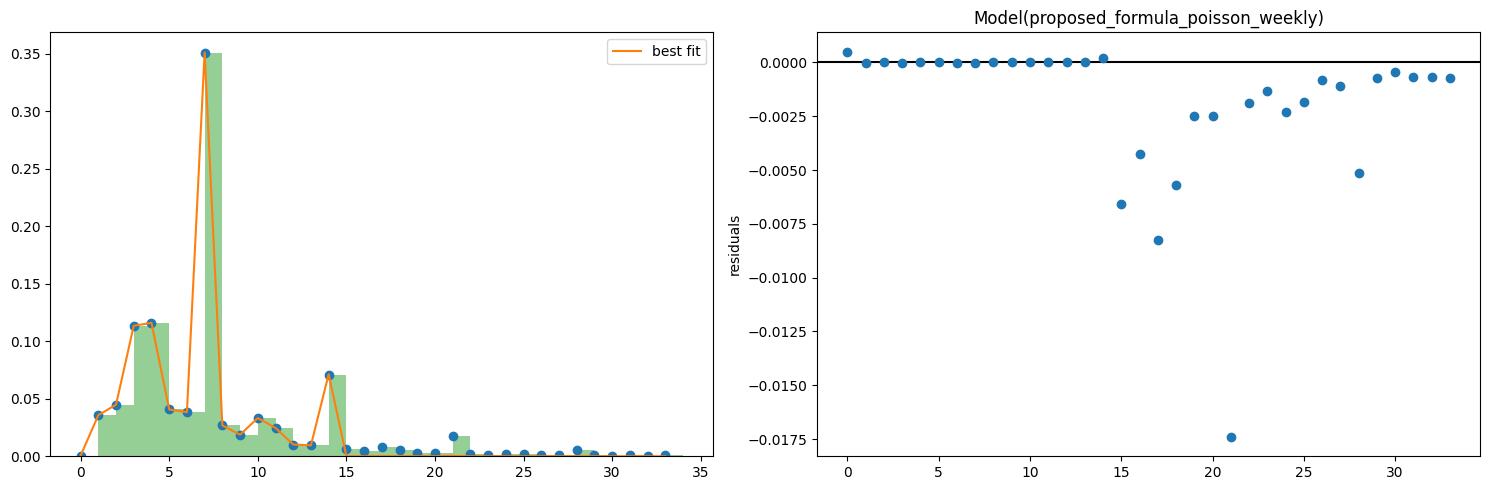

In [174]:
plot_result_custom(result)

By R-squared, and by the residuals, the best model is the one that uses the Poisson distribution for the weekly orders. The residuals are more centered around zero, and the R-squared is higher than the other models. The model is as follows: